# NASLib tutorial and intro to exercise

[NASLib](https://github.com/automl/NASLib) is framework that was built in order to facilitate neural architecture search (NAS) research and development. Please refer to the slides and to the [NAS survey paper](https://arxiv.org/abs/1808.05377) for more details. At the high-level NASLib consists of 4 main building blocks which (can) interact with each other:
- search spaces (cell search space, hierarchical, ...)
- optimizers (one-shot/weight-sharing optimizers, black-box optimizers)
- predictors (performance estimators that given an architecture as input, output its performance)
- evaluators (run the architecture search loop and the final network training pipeline)

**NOTE: NASLib is currently under development. This exercise is meant to be beneficial for both students and the NASLib developers. In case of any issues or bugs please contact us and we will try to fix those. If you are interested in working to extend the library please contact Arber.**

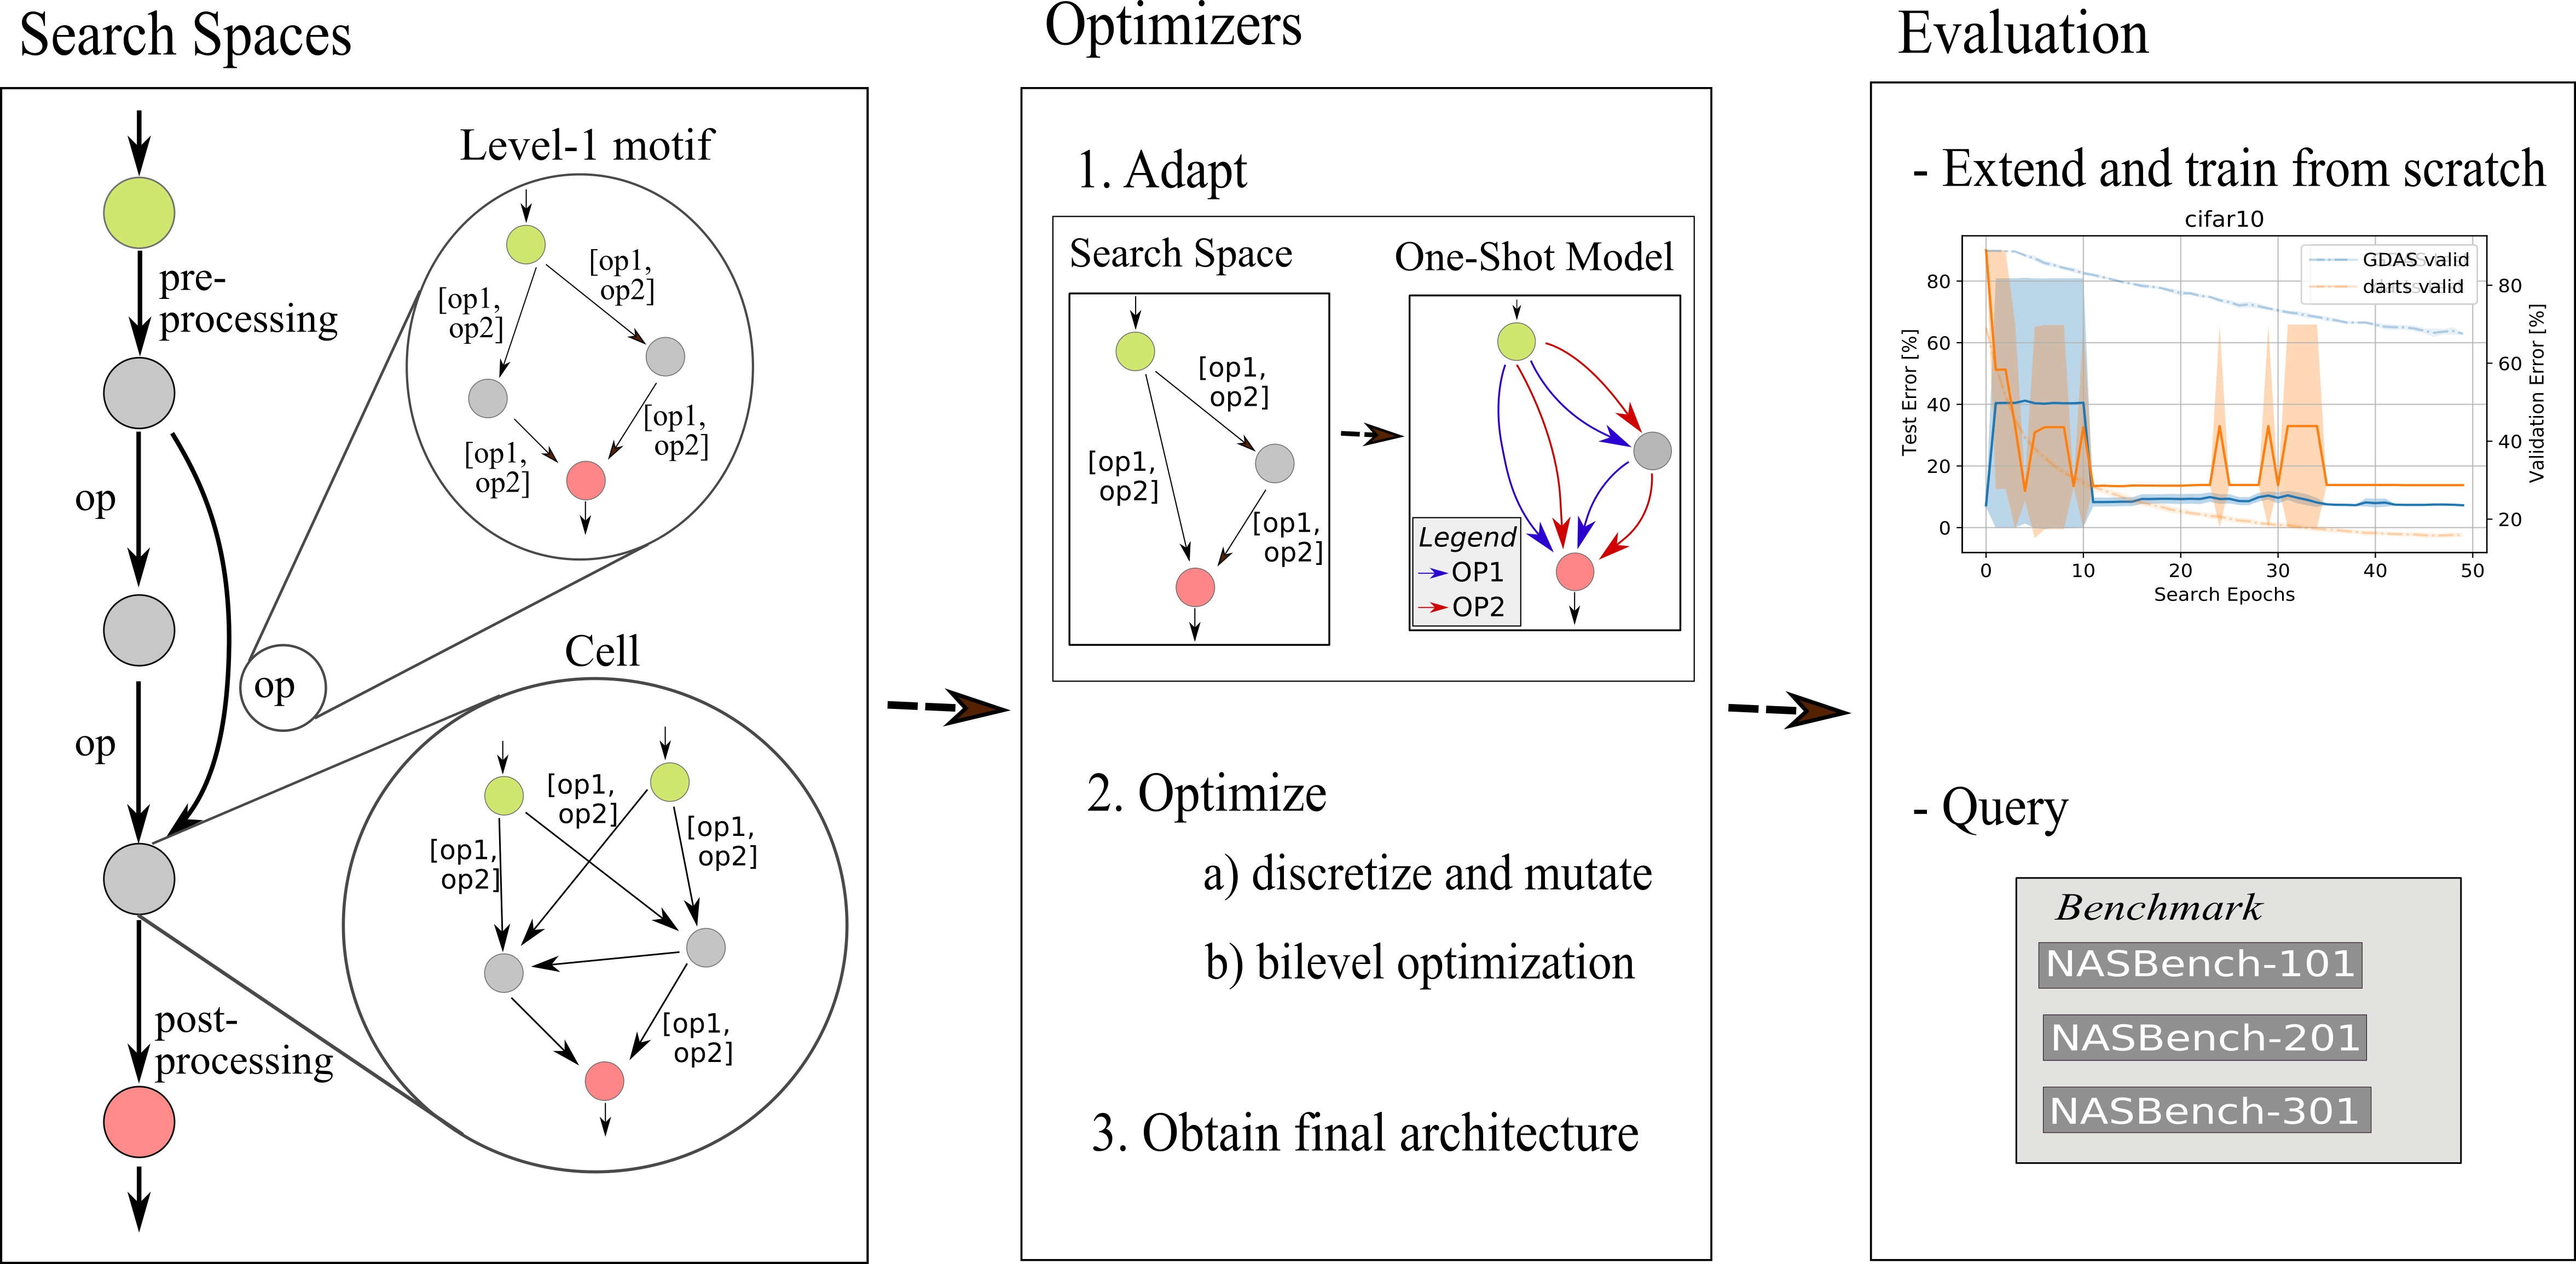

## Installation and setup 

To setup your environment and install NASLib follow these steps:
```
git clone -b dllab22 https://github.com/automl/NASLib/
cd NASLib
conda create -n naslib_exercises python=3.7
conda activate naslib_exercises
pip install --upgrade pip setuptools wheel
pip install -e .
pip install jupyter gdown
source scripts/download_data.sh nb201 cifar10
```


## Cell search spaces in NASLib 

The search space representation is of primary importance for NASLib in ensuring that optimizers and search spaces can be combined in a variety of ways. The predominant way of representing NAS search spaces is the directed acyclic graph (DAG). 
In order to accomplish the aforementioned functionality of search spaces and computational graphs, we inherit in our basic graph classes from both [PyTorch](https://pytorch.org/) and [NetworkX](https://github.com/networkx/networkx). The latter is a well-maintained and tested Python package for graph creation and manipulation, where node and edge attributes can be arbitrary Python objects. This framework allows us to represent multiple layers of graphs on top of the computational graph, allowing us to treat nodes and edges both as primitive operations (e.g. convolution), but also nested graph-structures such as a DARTS cell, to create e.g. macro architectures of stacked cells. NetworkX allows to easily construct the search space via `add_node`, `remove_node`, `add_edge`, `remove_edge`, or traverse the topologically sorted graph in the forward pass of the PyTorch module using `networkx.algorithms.dag.topological_sort`.

### Case study: NAS-Bench-201

[The NAS-Bench-201](https://openreview.net/forum?id=HJxyZkBKDr) is a tabular benchmark, i.e. a benchmark where you can simply query (already has been trained) the performance and other metrics of a specific architecture in the search space given that as an input. Its search space consists of a single normal cell which is replicated multiple times in a macro architecture interleaved by manually defined resnet-like reduction cells. The cell topology is fixed in the cell and consists of:
- 1 input, 2 intermediate and 1 output node;
- a summation operation on each of the intermediate and output nodes;
- 5 operation choices in each of the edges connecting 2 nodes
    - 'none'
    - 'skip_connect'
    - 'nor_conv_1x1'
    - 'nor_conv_3x3'
    - 'avg_pool_3x3'
    
For an example on how this search space is defined using the NASLib terminology, refer  [here](https://github.com/automl/NASLib/blob/predictors/naslib/search_spaces/nasbench201/graph.py).

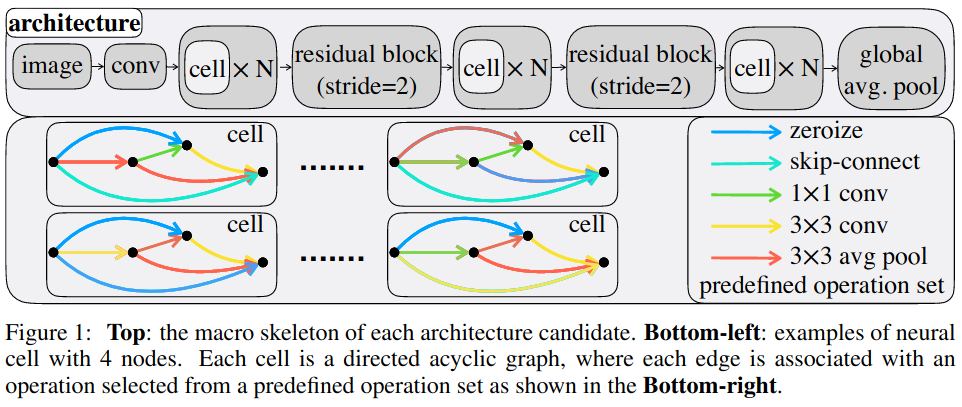

In [1]:
from naslib.search_spaces import NasBench201SearchSpace as NB201

# instantiate the search space object
search_space = NB201()

Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`


## Black-box optimizers in NASLib

After learning about the search space object, now we can add the other component of NAS: the NAS optimizer which you will use to search for an optimal architecture in that search space. A search space graph object can be interpreted in different ways depending on the type of optimizer being used. Here is the point where the search space and optimizer objects interact by parsing information from each other. 

In [2]:
# import some utilities and parse the configuration file
import logging

from naslib.utils import utils, setup_logger, get_dataset_api

# This will read the parameters from the default yaml configuration file, which in this 
# case is located in NASLib/naslib/benchmarks/nas_predictors/discrete_config.yaml.
# You do not have to change this but you can play around with its parameters.
config = utils.get_config_from_args(config_type="nas_predictor")
utils.set_seed(config.seed)
utils.log_args(config)

logger = setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)

Namespace(config_file='/home/lukas/NASLib/naslib/benchmarks/nas_predictors/discrete_config.yaml', dist_backend='nccl', dist_url='tcp://127.0.0.1:8888', eval_only=False, gpu=None, model_path=None, multiprocessing_distributed=False, opts=[], rank=0, resume=False, seed=0, world_size=1)


In [3]:
from naslib.optimizers import RegularizedEvolution as RE

# instantiate the optimizer object using the configuration file parameters
optimizer = RE(config)

device: cuda:0
device: cpu
device: cuda:0
device: cuda:0
device: cuda:0
device: cuda:0


After parsing the configuration file and instantiating the NAS optimizer and search space objects, we have to adapt the search space based on the optimizer type. 
A black-box optimizer such as Random Search will sample single architectures using the `sample_random_architecture` method of the search space object (e.g. by sampling one operation at each graph edge from the operation choices in NAS-Bench-201) throughout the optimization process.
On the other hand most one-shot optimizers, such as [DARTS](https://arxiv.org/abs/1806.09055), will interpret a set of operation choices on an edge as a `MixedOp` and assign an appropriate number of architectural weights (between 0 and 1, such that the sum is 1) to the outputs of each operation in order to obtain the continuous relaxation. 

Download the NAS-Bench-201 data from https://drive.google.com/file/d/17EBlTidimMaGrb3fE0APbljJl-ocgfs4/view?usp=sharing and place it in `NASLib/naslib/data/`. Alternatively run ```source scripts/download_data.sh nb201 cifar10```


In [4]:
# this will load the NAS-Bench-201 data (architectures and their accuracy, runtime, etc).
dataset_api = get_dataset_api(config.search_space, config.dataset)

# adapt the search space to the optimizer type
optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

## Running the search

Now the only step left is to run the search. Fro this we will use the `Trainer` object in NASLib:

In [5]:
from naslib.defaults.trainer import Trainer

# since the optimizer has parsed the information of the search space, we do not need to pass the search
# space object to the trainer when instantiating it.
trainer = Trainer(optimizer, config, lightweight_output=True)

[05/13 17:34:02 nl.defaults.trainer]: param size = 0.000000MB


In [6]:
# call only a method to run the search for the number of iterations specified in the yaml configuration file.
trainer.search()

[05/13 17:34:02 nl.defaults.trainer]: Start training
[05/13 17:34:02 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
WARNING [05/13 17:34:03 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
WARNING [05/13 17:34:03 nl.search_spaces.core.graph]: Update function could not be veryfied. Be cautious with the setting of `private_edge_data` in `update_edges()`
[05/13 17:34:03 nl.optimizers.discrete.re.optimizer]: Population size 1
[05/13 17:34:03 nl.defaults.trainer]: Epoch 0, Anytime results: {'cifar10-valid': {'train_losses': [1.933049173965454, 1.6435673345184325, 1.5047246058654786, 1.3834531283569336, 1.286956615371704, 1.1839038812637328, 1.1257015887069701, 1.0640545072746277, 1.008200834274292, 0.9675810929870605, 0.9294775085449218, 0.8978886487960815, 0.8689233894729614, 0.835043701877594, 0.8149485078430175, 0.7993172987365723, 0.7647924902915955, 0.7

[05/13 17:34:03 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:03 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/13 17:34:03 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:03 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/13 17:34:03 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:03 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/13 17:34:03 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:03 nl.optimizers.discrete.re.optimizer]: Start sampling architectures to fill the population
[05/13 17:34:03 nl.d

[05/13 17:34:08 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 33, Anytime results: {'cifar10-valid': {'train_losses': [1.7726301501464843, 1.2632741512680055, 1.0350315731430053, 0.9116640870666504, 0.8138554672622681, 0.7384605021095276, 0.6771002819061279, 0.6386288579177857, 0.5977942006492615, 0.566234061164856, 0.5407228638648987, 0.5169966495037079, 0.5059799674415588, 0.49211094816207884, 0.47442392370224, 0.4547991913414001, 0.45366372842788694, 0.44375011929512026, 0.4291874082946777, 0.4207805109882355, 0.4070393644332886, 0.4128223983192444, 0.3933644982147217, 0.3912780677032471, 0.39287704973220827, 0.37701327048301697, 0.3703632626247406, 0.36252842462539675, 0.3545865700340271, 0.36439799418449403, 0.35175954774856566, 0.352374792804718, 0.3494409676837921, 0.34050146408081056, 0.33357596693992614, 0.3253499046516418, 0.3226811494445801, 0.32070203971

[05/13 17:34:08 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:08 nl.defaults.trainer]: Epoch 39 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:08 nl.d

[05/13 17:34:13 nl.defaults.trainer]: Epoch 69 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:13 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:13 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:13 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:14 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:14 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:14 nl.defaults.trainer]: Epoch 75 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.80000, 0.00000
[05/13 17:34:14 nl.d

In [7]:
# After the search is done, we want to evaluate the test performance of
# the best architecture found using the validation set.
trainer.evaluate(dataset_api=dataset_api)

[05/13 17:34:17 nl.defaults.trainer]: Start evaluation
[05/13 17:34:17 nl.defaults.trainer]: loading model from file run/cifar10/nas_predictors/nasbench201/var_sparse_gp/0/search/model_final.pth
[05/13 17:34:17 nl.defaults.trainer]: Final architecture:
Graph makrograph-0.4823693, scope None, 20 nodes
[05/13 17:34:17 nl.defaults.trainer]: Queried results (Metric.TEST_ACCURACY): 90.8


## NAS predictors

The performance predictors in NASLib are categorized in 4 classes:
- *Model-based predictors*
    - These are usually regression models (e.g. Gaussian Processes or XGBoost) that are trained with a data (x, y), where x is the architecture encoding and y is the validation performance of the trained architectures. At test time, they predict the performance of new architectures from the space.
- *Learning curve predictors*
    - These predictors estimate the architecture ranking (e.g. at epoch 100) by using the performance at a lower epoch or some other statistics. An example is early stopping. By early stopping the training at epoch 30, we hope that the ranking of the architectures will be the same as the ranking at epoch 100.
- *Zero-cost predictors*
    - These predictors usually run only a single mini-batch iteration through a sampled architecture and use some statistics (e.g. norm of gradients) in order to determine how good that architecture is.
- *One-shot predictors*
    - This class of predictors utilizes the shared weights of the one-shot model in order to rank the architectures based on the validation performance using these shared weights.
    
In NASLib we have implemented **31 predictors** that can be easily imported and evaluated on the tabular benchmarks. Check also this file for some more details: https://github.com/automl/NASLib/blob/master/docs/predictors.md and our paper: https://arxiv.org/abs/2104.01177

In [8]:
# Load the predictor evaluator and the predictor (XGBoost in this case)
from naslib.defaults.predictor_evaluator import PredictorEvaluator
from naslib.predictors import XGBoost

# read the new configuration file that has the parameters of the predictor model
# NOTE: it is important to set config_type="predictor" here
config = utils.get_config_from_args(args=["--config-file", "../naslib/benchmarks/predictors/predictor_config.yaml"], 
                                    config_type="predictor")
utils.set_seed(config.seed)
utils.log_args(config)

logger = setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)

# Now instantiate the predictor (every predictor works with certain encoding types for the architecture)
predictor = XGBoost(encoding_type='adjacency_one_hot', hpo_wrapper=False)
# Instantiate the evaluator
predictor_evaluator = PredictorEvaluator(predictor, config=config)
# similarly to the conventional NAS search that we saw before, the predictor evaluator also adapts to 
# the search space at hand
predictor_evaluator.adapt_search_space(search_space, load_labeled=False, 
                                       dataset_api=dataset_api)
# No search in this case. We only train the predictor on the training data and evaluate it on the test data.
# Note that the training data here is the pair (arch, performance) and not (image, label).
predictor_evaluator.evaluate()

['--config-file', '../naslib/benchmarks/predictors/predictor_config.yaml']
[05/13 17:34:17 nl.utils.utils]: Command line args: ['--config-file', '../naslib/benchmarks/predictors/predictor_config.yaml']
[05/13 17:34:17 nl.utils.utils]: Experiment dir : run/cifar10/predictors/xgb/1000
[05/13 17:34:17 nl.utils.utils]: Experiment dir : run/cifar10/predictors/xgb/1000/search
[05/13 17:34:17 nl.utils.utils]: Experiment dir : run/cifar10/predictors/xgb/1000/eval
[05/13 17:34:17 nl.utils.utils]: experiment_type.............................single
[05/13 17:34:17 nl.utils.utils]: search_space...........................nasbench201
[05/13 17:34:17 nl.utils.utils]: dataset....................................cifar10
[05/13 17:34:17 nl.utils.utils]: predictor......................................xgb
[05/13 17:34:17 nl.utils.utils]: uniform_random...................................1
[05/13 17:34:17 nl.utils.utils]: test_size......................................100
[05/13 17:34:17 nl.utils.utils]: tra

[CfgNode({'experiment_type': 'single', 'search_space': 'nasbench201', 'dataset': 'cifar10', 'predictor': 'xgb', 'uniform_random': 1, 'test_size': 100, 'train_size_single': 50, 'train_size_list': [5, 8, 14, 24, 42, 71, 121, 205], 'fidelity_single': 5, 'fidelity_list': [1, 2, 3, 5, 7, 9, 13, 19, 26, 37, 52, 73], 'out_dir': 'run', 'max_hpo_time': 0, 'seed': 1000, 'search': CfgNode({'seed': 1000, 'batch_size': 256, 'data_size': 25000, 'cutout': False, 'cutout_length': 16, 'cutout_prob': 1.0, 'train_portion': 0.7}), 'save': 'run/cifar10/predictors/xgb/1000', 'data': '/home/lukas/NASLib/naslib/data'}),
 {'mae': 4.320324826049804,
  'rmse': 8.385226457743993,
  'pearson': 0.3591196355192593,
  'spearman': 0.48864365998706494,
  'kendalltau': 0.35577120352397784,
  'kt_2dec': 0.35567687978766804,
  'kt_1dec': 0.3563206034824803,
  'precision_10': 0.5,
  'precision_20': 0.45,
  'train_size': 50,
  'fidelity': 5,
  'train_time': 462.41313511133194,
  'fit_time': 0.05837821960449219,
  'query_tim

The stdout shows some metrics such as the rank correlation (Spearman or Kendall Tau) of 100 sampled architectures from the test set. This shows how good the ranking of the architectures based on the performance predictor is compared to the true ranking from NAS-Bench-201.

## Using the predictors as surrogate models in Bayesian Optimization

In order to use the aforementioned predictors as surrogate models inside Bayesian Optimization, we need to have a mean prediction and uncertainty estimates for every architecture. Some of the models (e.g. GPs) already provide this, but for some others such as MLPs we construct an ensemble of MLPs in order to obtain the uncertainty estimates.

This code snippet shows how to run [BANANAS](https://arxiv.org/abs/1910.11858) with some of the performance predictors as surrogate models. We will do 3 trials with 3 different seeds of BANANAS for 300 iterations. For this we need to firstly generate the configuration files. The bash commands below do this. 

In [9]:
%%bash
optimizer=bananas
predictors=(mlp lgb xgb rf bayes_lin_reg gp)

start_seed=0

# folders:
# this supposes your location is at NASLib/docs. Change the base_file location based on where you
# opened the notebook
base_file=../naslib
save_dir=bananas_run
out_dir=$save_dir\_$start_seed

# search space / data:
search_space=nasbench201
dataset=cifar10
search_epochs=100

# trials / seeds:
trials=3
end_seed=$(($start_seed + $trials - 1))

# create config files
for i in $(seq 0 $((${#predictors[@]}-1)) )
do
    predictor=${predictors[$i]}
    python $base_file/benchmarks/create_configs.py --predictor $predictor \
    --epochs $search_epochs --start_seed $start_seed --trials $trials \
    --out_dir $out_dir --dataset=$dataset --config_type nas_predictor \
    --search_space $search_space --optimizer $optimizer
done

Similarly to how we ran RE before, write a function that gets a configuration file and optimizer as input and runs them.

In [10]:
import logging
from naslib.search_spaces import NasBench201SearchSpace as NB201

# instantiate the search space object
search_space = NB201()

from naslib.optimizers import Bananas
from naslib.utils import utils, setup_logger, get_dataset_api
from naslib.defaults.trainer import Trainer

def run_optimizer(config_file="../docs/bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml",
                  nas_optimizer=Bananas) -> None:
    # TODO: add all the utilities, such as config file reading, logging as before.
    # afterwards instantiate the search space, optimizer, trainer and run the search + evaluation
    config = utils.get_config_from_args(args=["--config-file", config_file], 
                                        config_type="nas_predictor")
    
    utils.set_seed(config.seed)
    utils.log_args(config)
    
    dataset_api = get_dataset_api(config.search_space, config.dataset)
    
    nas_optimizer = nas_optimizer(config)
    nas_optimizer.adapt_search_space(search_space, dataset_api=dataset_api)
    
    logger = setup_logger(config.save + "/log.log")
    logger.setLevel(logging.INFO)
    
    trainer = Trainer(nas_optimizer, config, lightweight_output=True)
    
    trainer.search()
    trainer.evaluate(dataset_api=dataset_api)

In [11]:
run_optimizer()

['--config-file', '../docs/bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml']
[05/13 17:34:39 nl.utils.utils]: Command line args: ['--config-file', '../docs/bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml']
[05/13 17:34:39 nl.utils.utils]: Experiment dir : bananas_run_0/cifar10/nas_predictors/nasbench201/gp/0
[05/13 17:34:39 nl.utils.utils]: Experiment dir : bananas_run_0/cifar10/nas_predictors/nasbench201/gp/0/search
[05/13 17:34:39 nl.utils.utils]: Experiment dir : bananas_run_0/cifar10/nas_predictors/nasbench201/gp/0/eval
[05/13 17:34:39 nl.utils.utils]: dataset....................................cifar10
[05/13 17:34:39 nl.utils.utils]: optimizer..................................bananas
[05/13 17:34:39 nl.utils.utils]: out_dir..............................bananas_run_0
[05/13 17:34:39 nl.utils.utils]: searchacq_fn_optimization: random_sampling
acq_fn_type: its
batch_size: 256
checkpoint_freq: 5000
cutout: False
cutout_length: 16
cutout_prob

[05/13 17:34:40 nl.defaults.trainer]: Epoch 0 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:40 nl.defaults.trainer]: Epoch 1 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:40 nl.defaults.trainer]: Epoch 2 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:40 nl.defaults.trainer]: Epoch 3 done. Train accuracy (top1, top5): 99.11600, 0.00000, Validation accuracy: 86.81000, 0.00000
[05/13 17:34:40 nl.defaults.trainer]: Epoch 4 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:34:41 nl.defaults.trainer]: Epoch 5 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:34:41 nl.defaults.trainer]: Epoch 6 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:34:41 nl.defaults

/home/lukas/anaconda3/envs/naslib_exercises/lib/python3.7/site-packages/pyro/contrib/gp/models/gpr.py:126: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  Lff = Kff.cholesky()
/home/lukas/anaconda3/envs/naslib_exercises/lib/python3.7/site-packages/pyro/contrib/gp/util.py:109: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
shoul

[05/13 17:35:11 nl.defaults.trainer]: Epoch 20, Anytime results: {'cifar10-valid': {'train_losses': [1.7726301501464843, 1.2632741512680055, 1.0350315731430053, 0.9116640870666504, 0.8138554672622681, 0.7384605021095276, 0.6771002819061279, 0.6386288579177857, 0.5977942006492615, 0.566234061164856, 0.5407228638648987, 0.5169966495037079, 0.5059799674415588, 0.49211094816207884, 0.47442392370224, 0.4547991913414001, 0.45366372842788694, 0.44375011929512026, 0.4291874082946777, 0.4207805109882355, 0.4070393644332886, 0.4128223983192444, 0.3933644982147217, 0.3912780677032471, 0.39287704973220827, 0.37701327048301697, 0.3703632626247406, 0.36252842462539675, 0.3545865700340271, 0.36439799418449403, 0.35175954774856566, 0.352374792804718, 0.3494409676837921, 0.34050146408081056, 0.33357596693992614, 0.3253499046516418, 0.3226811494445801, 0.32070203971862793, 0.32613728584289553, 0.3122583133125305, 0.31861459453582763, 0.29858239007949827, 0.3031420729446411, 0.29814767778396606, 0.301887

[05/13 17:35:11 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.defaults.trainer]: Epoch 23 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.defaults.trainer]: Epoch 24 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.defaults.trainer]: Epoch 25 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.defaults.trainer]: Epoch 26 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:11 nl.d

[05/13 17:35:40 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.defaults.trainer]: Epoch 45 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.defaults.trainer]: Epoch 46 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
[05/13 17:35:40 nl.d

[05/13 17:36:09 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.defaults.trainer]: Epoch 65 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.defaults.trainer]: Epoch 66 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 90.51000, 0.00000
[05/13 17:36:09 nl.d

[05/13 17:36:39 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.defaults.trainer]: Epoch 85 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.defaults.trainer]: Epoch 86 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.78000, 0.00000
[05/13 17:36:39 nl.d

# TASK: Implement a Regularized Evolution version that uses the performance predictors as surrogate models during the search

The Regularized Evolution (RE) code that we ran above uses the true validation performance as queried from NAS-Bench-201. Using the tabular benchmark this is certainly cheap since we are only simulating the true run. However, in real world scenarios these tabular entries are not available so we have to train every sampled/mutated architecture from scratch. This is the most expensive step in black-box optimization for NAS.

The NAS performance predictors can drastically accelerate the search by utilizing the performance as predicted by the surrogate model (performance predictor). In this exercise you will have to implement a RE version that utilizes the performance predictors to estimate the performance of the sampled architectures instead of querying that from the tabular benchmark. Sample the very first architectures in the population and query those from NB201. Then fit the performance predictor. Afterwards, every 10 iterations query again the performance from NB201 and refit the predictor. In between, however, use the performance returned by the predictor inside RE.

HINT: Check how the performance predictors are utilized inside the BANANAS implementation in NASLib.

In [12]:
from naslib.optimizers import RegularizedEvolution as RE

import torch
import numpy as np

from naslib.utils.logging import log_every_n_seconds
from naslib.optimizers.discrete.bananas.acquisition_functions import acquisition_function
from naslib.predictors.ensemble import Ensemble
from naslib.utils.utils import get_train_val_loaders

from naslib.utils import utils, setup_logger, get_dataset_api


class RE_predictor(RE):
    def __init__(self, config):
        super().__init__(config)
        
        self.k = config.search.k
        self.num_ensemble = config.search.num_ensemble
        self.predictor_type = config.search.predictor_type
        self.acq_fn_type = config.search.acq_fn_type
        self.acq_fn_optimization = config.search.acq_fn_optimization
        self.num_arches_to_mutate = config.search.num_arches_to_mutate
        self.max_mutations = config.search.max_mutations
        self.num_candidates = config.search.num_candidates
        self.train_data = []
        
        # you might need to reduce this value referring to your machine
        self.len_buffer = 100
    
    def adapt_search_space(self, search_space, scope=None, dataset_api=None):
        assert search_space.QUERYABLE, "Regularized evolution is currently only implemented for benchmarks."
        self.search_space = search_space.clone()
        self.scope = scope if scope else search_space.OPTIMIZER_SCOPE
        self.dataset_api = dataset_api
        self.ss_type = self.search_space.get_type()
        
        # fit early so fit can be used as re_fit
        self.ensemble = Ensemble(num_ensemble=self.num_ensemble,
                                 ss_type=self.ss_type,
                                 predictor_type=self.predictor_type,
                                 config=self.config)

    def new_epoch(self, epoch):
        print(f"new on epoch {epoch}")
        if epoch < self.population_size:
            # logger.info("Start sampling architectures to fill the population")
            # If there is no scope defined, let's use the search space default one
            model = torch.nn.Module()   # hacky way to get arch and accuracy checkpointable
            model.arch = self.search_space.clone()
            model.arch.sample_random_architecture(dataset_api=self.dataset_api)
            # Todo change this estimate query to a model prediction
            model.accuracy = model.arch.query(self.performance_metric,
                                              self.dataset,
                                              dataset_api=self.dataset_api)
            

            self.population.append(model)
            self.train_data.append(model)
            self._update_history(model)
            log_every_n_seconds(logging.INFO, "Population size {}".format(len(self.population)))
        
        else:
            if epoch % 10 == 0 or epoch == self.population_size:
                xtrain = [m.arch for m in self.train_data]
                ytrain = [m.accuracy for m in self.train_data]
                if epoch > self.population_size:
                    print(f"add new config to trainset!")
                    print(f"acq_fn: {self.acq_fn_type}")
                    acq_fn = acquisition_function(ensemble=self.ensemble,
                                                  ytrain=ytrain,
                                                  acq_fn_type=self.acq_fn_type)
                    
                    candidates = []
                    for _ in range(self.num_candidates):
                        arch = self.search_space.clone()
                        arch.sample_random_architecture(dataset_api=self.dataset_api)
                        candidates.append(arch)
                    
                    # acq values for sampled archs
                    values = [acq_fn(encoding) for encoding in candidates]
                    sorted_indices = np.argsort(values)[-self.k:]
                    print(f"(value, sorted_idx) in {[(value, idx, values[idx]) for value, idx in zip(values, sorted_indices)]}\n")
                    
                    for i in sorted_indices:
                        model = torch.nn.Module()   # hacky way to get arch and accuracy checkpointable
                        model.arch = candidates[i]
                        model.accuracy = model.arch.query(self.performance_metric,
                                                          self.dataset,
                                                          dataset_api=self.dataset_api)
                        print(f"add model.arch: {model.arch}\n"
                              f"model.accuracy: {model.accuracy}\n\n")
                        print(f"self.train_data: {len(self.train_data)}")
                        self.train_data.append(model)
                        print(f"self.train_data: {len(self.train_data)}")
                        
                    # delete old values to save storage
                    print(f"len_buffer: {len(self.train_data)}")
                    if len(self.train_data) > self.len_buffer:
                        self.train_data = self.train_data[len(sorted_indices):]
                    
                    # update train
                    xtrain = [m.arch for m in self.train_data]
                    ytrain = [m.accuracy for m in self.train_data]
                    
                    # Todo sample a new configuration and eval on query (acq_fn)

                train_error = self.ensemble.fit(xtrain, ytrain)

            
            sample = []
            while len(sample) < self.sample_size:
                candidate = np.random.choice(list(self.population))
                sample.append(candidate)

            parent = max(sample, key=lambda x: x.accuracy)

            child = torch.nn.Module()   # hacky way to get arch and accuracy checkpointable
            child.arch = self.search_space.clone()
            child.arch.mutate(parent.arch, dataset_api=self.dataset_api)
            
            # Todo estimate here with fitted model
            child.accuracy = np.mean(self.ensemble.query([child.arch]))
            print(f"child acc on epoch {epoch}: {child.accuracy}")

            self.population.append(child)
            self._update_history(child)

Now generate the new yaml configuration files using the bash commands as shown above. Just change "bananas" to "re".

In [13]:
%%bash
optimizer=re
predictors=(mlp lgb xgb rf bayes_lin_reg gp)

start_seed=0

# folders:
# this supposes your location is at NASLib/docs. Change the base_file location based on where you
# opened the notebook
base_file=../naslib
save_dir=re_run
out_dir=$save_dir\_$start_seed

# search space / data:
search_space=nasbench201
dataset=cifar10
search_epochs=100

# trials / seeds:
trials=3
end_seed=$(($start_seed + $trials - 1))

# create config files
for i in $(seq 0 $((${#predictors[@]}-1)) )
do
    predictor=${predictors[$i]}
    python $base_file/benchmarks/create_configs.py --predictor $predictor \
    --epochs $search_epochs --start_seed $start_seed --trials $trials \
    --out_dir $out_dir --dataset=$dataset --config_type nas_predictor \
    --search_space $search_space --optimizer $optimizer
done

In [ ]:
#TODO: Run the RE_predictor optimizer
import os

path = "re_run_0/cifar10/configs/nas_predictors/"
list_of_config_files = [f"{path}{file}" for file in os.listdir(path)]

for config_file in list_of_config_files:
    run_optimizer(config_file=config_file, nas_optimizer=RE_predictor)

['--config-file', 're_run_0/cifar10/configs/nas_predictors/config_re_mlp_2.yaml']
[05/13 17:36:41 nl.utils.utils]: Command line args: ['--config-file', 're_run_0/cifar10/configs/nas_predictors/config_re_mlp_2.yaml']
[05/13 17:36:41 nl.utils.utils]: Experiment dir : re_run_0/cifar10/nas_predictors/nasbench201/mlp/2
[05/13 17:36:41 nl.utils.utils]: Experiment dir : re_run_0/cifar10/nas_predictors/nasbench201/mlp/2/search
[05/13 17:36:41 nl.utils.utils]: Experiment dir : re_run_0/cifar10/nas_predictors/nasbench201/mlp/2/eval
[05/13 17:36:41 nl.utils.utils]: dataset....................................cifar10
[05/13 17:36:41 nl.utils.utils]: optimizer.......................................re
[05/13 17:36:41 nl.utils.utils]: out_dir...................................re_run_0
[05/13 17:36:41 nl.utils.utils]: searchacq_fn_optimization: random_sampling
acq_fn_type: its
batch_size: 256
checkpoint_freq: 5000
cutout: False
cutout_length: 16
cutout_prob: 1.0
data_size: 25000
encoding_type: adjacenc

[05/13 17:36:44 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 20
[05/13 17:36:45 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 21
[05/13 17:36:45 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 22
[05/13 17:36:45 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 23
[05/13 17:36:45 nl.defaults.trainer]: Epoch 23 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 24
[05/13 17:36:45 nl.defaults.trainer]: Epoch 24 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 25
[05/13 17:36:45 nl.defaults.trainer]: Epoch 25 done. Train accur

[05/13 17:36:50 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.93600, 0.00000, Validation accuracy: 88.84000, 0.00000
new on epoch 31
child acc on epoch 31: 90.19281005859375
[05/13 17:36:50 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.93600, 0.00000, Validation accuracy: 88.84000, 0.00000
new on epoch 32
child acc on epoch 32: 87.8666000366211
[05/13 17:36:50 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.93600, 0.00000, Validation accuracy: 88.84000, 0.00000
new on epoch 33
child acc on epoch 33: 86.08055877685547
[05/13 17:36:51 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.93600, 0.00000, Validation accuracy: 88.84000, 0.00000
new on epoch 34
child acc on epoch 34: 83.4748306274414
[05/13 17:36:51 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.93600, 0.00000, Validation accuracy: 88.84000, 0.00000
new on epoch 35
child acc on epoch 35: 84.58767700195312
[05/13 17:36:52 n

[05/13 17:37:30 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 41
child acc on epoch 41: 87.78829193115234
[05/13 17:37:30 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 42
child acc on epoch 42: 89.64241790771484
[05/13 17:37:30 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 43
child acc on epoch 43: 91.04056549072266
[05/13 17:37:31 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 44
child acc on epoch 44: 87.53399658203125
[05/13 17:37:31 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 45
child acc on epoch 45: 92.04010772705078
[05/13 17:37:31

[05/13 17:38:14 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 51
child acc on epoch 51: 90.35611724853516
[05/13 17:38:14 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 52
child acc on epoch 52: 92.6065902709961
[05/13 17:38:14 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 53
child acc on epoch 53: 90.2528076171875
[05/13 17:38:14 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 54
child acc on epoch 54: 89.11043548583984
[05/13 17:38:14 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 55
child acc on epoch 55: 92.47796630859375
[05/13 17:38:14 n

[05/13 17:38:59 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 61
child acc on epoch 61: 88.5066909790039
[05/13 17:38:59 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 62
child acc on epoch 62: 90.38861846923828
[05/13 17:38:59 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 63
child acc on epoch 63: 92.6391372680664
[05/13 17:38:59 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 64
child acc on epoch 64: 88.3193359375
[05/13 17:39:00 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.99200, 0.00000, Validation accuracy: 91.13000, 0.00000
new on epoch 65
child acc on epoch 65: 93.24517822265625
[05/13 17:39:00 nl.de

[05/13 17:39:49 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 71
child acc on epoch 71: 86.2569351196289
[05/13 17:39:49 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 72
child acc on epoch 72: 89.3633804321289
[05/13 17:39:50 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 73
child acc on epoch 73: 85.267333984375
[05/13 17:39:50 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 74
child acc on epoch 74: 83.10794067382812
[05/13 17:39:50 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 75
child acc on epoch 75: 81.7796401977539
[05/13 17:39:50 nl.d

[05/13 17:40:37 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 81
child acc on epoch 81: 81.44562530517578
[05/13 17:40:37 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 82
child acc on epoch 82: 80.48455810546875
[05/13 17:40:37 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 83
child acc on epoch 83: 79.6376724243164
[05/13 17:40:37 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 84
child acc on epoch 84: 84.41175079345703
[05/13 17:40:37 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 85
child acc on epoch 85: 84.50980377197266
[05/13 17:40:38 

[05/13 17:41:27 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 91
child acc on epoch 91: 92.634033203125
[05/13 17:41:27 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 92
child acc on epoch 92: 89.4529037475586
[05/13 17:41:28 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 93
child acc on epoch 93: 87.5627212524414
[05/13 17:41:28 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 94
child acc on epoch 94: 88.86444091796875
[05/13 17:41:28 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 95
child acc on epoch 95: 80.1739730834961
[05/13 17:41:28 nl.d

[05/13 17:41:32 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 16
[05/13 17:41:33 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 17
[05/13 17:41:33 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 18
[05/13 17:41:33 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 19
[05/13 17:41:33 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 20
[05/13 17:41:33 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 21
[05/13 17:41:33 nl.defaults.trainer]: Epoch 21 done. Train accur

child acc on epoch 40: 87.04177411050375
[05/13 17:42:12 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.7726301501464843, 1.2632741512680055, 1.0350315731430053, 0.9116640870666504, 0.8138554672622681, 0.7384605021095276, 0.6771002819061279, 0.6386288579177857, 0.5977942006492615, 0.566234061164856, 0.5407228638648987, 0.5169966495037079, 0.5059799674415588, 0.49211094816207884, 0.47442392370224, 0.4547991913414001, 0.45366372842788694, 0.44375011929512026, 0.4291874082946777, 0.4207805109882355, 0.4070393644332886, 0.4128223983192444, 0.3933644982147217, 0.3912780677032471, 0.39287704973220827, 0.37701327048301697, 0.3703632626247406, 0.36252842462539675, 0.3545865700340271, 0.36439799418449403, 0.35175954774856566, 0.352374792804718, 0.3494409676837921, 0.34050146408081056, 0.33357596693992614, 0.3253499046516418, 0.3226811494445801, 0.32070203971862793, 0.32613728584289553, 0.3122583133125305, 0.31861459453582763, 0.29858239007949827, 0.303142

[05/13 17:42:12 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 41
child acc on epoch 41: 88.15190267929707
[05/13 17:42:12 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 42
child acc on epoch 42: 88.51965214941089
[05/13 17:42:12 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 43
child acc on epoch 43: 88.23991265694714
[05/13 17:42:13 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 44
child acc on epoch 44: 88.92431810458858
[05/13 17:42:13 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 45
child acc on epoch 45: 88.50393227585793
[05/13 17:42:13

[05/13 17:42:52 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 51
child acc on epoch 51: 88.61550304370842
[05/13 17:42:52 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 52
child acc on epoch 52: 86.66491365937702
[05/13 17:42:52 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 53
child acc on epoch 53: 88.78753529536397
[05/13 17:42:52 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 54
child acc on epoch 54: 88.99731245737819
[05/13 17:42:52 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 55
child acc on epoch 55: 87.5069197614327
[05/13 17:42:52 

[05/13 17:43:30 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 61
child acc on epoch 61: 84.55343378986913
[05/13 17:43:30 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 62
child acc on epoch 62: 82.40648535851122
[05/13 17:43:30 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 63
child acc on epoch 63: 82.48975053490571
[05/13 17:43:31 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 64
child acc on epoch 64: 82.17634265997413
[05/13 17:43:31 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 65
child acc on epoch 65: 81.4853911342489
[05/13 17:43:31 

[05/13 17:44:09 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 71
child acc on epoch 71: 84.7314238847838
[05/13 17:44:09 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 72
child acc on epoch 72: 88.14946736333589
[05/13 17:44:10 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 73
child acc on epoch 73: 84.86542549601627
[05/13 17:44:10 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 74
child acc on epoch 74: 84.87642570127078
[05/13 17:44:10 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 75
child acc on epoch 75: 88.8631399073468
[05/13 17:44:10 n

[05/13 17:44:48 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 81
child acc on epoch 81: 87.82373408440219
[05/13 17:44:48 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 82
child acc on epoch 82: 87.78503409808582
[05/13 17:44:48 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 83
child acc on epoch 83: 87.66129572917504
[05/13 17:44:49 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 84
child acc on epoch 84: 89.46603864749555
[05/13 17:44:49 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 85
child acc on epoch 85: 88.96798940331699
[05/13 17:44:49

[05/13 17:45:24 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 91
child acc on epoch 91: 87.89359036485546
[05/13 17:45:24 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 92
child acc on epoch 92: 87.74366344686602
[05/13 17:45:25 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 93
child acc on epoch 93: 87.33390123836891
[05/13 17:45:25 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 94
child acc on epoch 94: 87.52096929164385
[05/13 17:45:25 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 95
child acc on epoch 95: 87.32861324347748
[05/13 17:45:25

[05/13 17:45:29 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 16
[05/13 17:45:30 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 17
[05/13 17:45:30 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 18
[05/13 17:45:30 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 19
[05/13 17:45:31 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 20
[05/13 17:45:31 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 21
[05/13 17:45:31 nl.defaults.trainer]: Epoch 21 done. Train accur

[05/13 17:45:36 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 31
child acc on epoch 31: 79.19232940673828
[05/13 17:45:37 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 32
child acc on epoch 32: 94.5951156616211
[05/13 17:45:37 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 33
child acc on epoch 33: 84.633056640625
[05/13 17:45:37 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 34
child acc on epoch 34: 89.8471450805664
[05/13 17:45:37 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 35
child acc on epoch 35: 89.28118133544922
[05/13 17:45:37 nl.

[05/13 17:46:19 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 41
child acc on epoch 41: 90.6887435913086
[05/13 17:46:19 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 42
child acc on epoch 42: 86.5331039428711
[05/13 17:46:19 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 43
child acc on epoch 43: 84.81475830078125
[05/13 17:46:19 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 44
child acc on epoch 44: 86.11968231201172
[05/13 17:46:20 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 45
child acc on epoch 45: 87.50623321533203
[05/13 17:46:20 n

[05/13 17:47:01 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 51
child acc on epoch 51: 80.35953521728516
[05/13 17:47:01 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 52
child acc on epoch 52: 84.80741119384766
[05/13 17:47:02 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 53
child acc on epoch 53: 83.6959457397461
[05/13 17:47:02 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 54
child acc on epoch 54: 85.96664428710938
[05/13 17:47:02 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 55
child acc on epoch 55: 90.47148895263672
[05/13 17:47:02 

[05/13 17:47:46 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 61
child acc on epoch 61: 84.13883209228516
[05/13 17:47:46 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 62
child acc on epoch 62: 87.90460205078125
[05/13 17:47:46 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 63
child acc on epoch 63: 86.3335952758789
[05/13 17:47:46 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 64
child acc on epoch 64: 82.6182861328125
[05/13 17:47:46 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 65
child acc on epoch 65: 82.92363739013672
[05/13 17:47:46 n

[05/13 17:48:30 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 71
child acc on epoch 71: 84.1999740600586
[05/13 17:48:30 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 72
child acc on epoch 72: 80.42880249023438
[05/13 17:48:30 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 73
child acc on epoch 73: 79.21259307861328
[05/13 17:48:30 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 74
child acc on epoch 74: 87.93749237060547
[05/13 17:48:31 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 75
child acc on epoch 75: 86.36048126220703
[05/13 17:48:31 

[05/13 17:49:16 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 81
child acc on epoch 81: 90.54449462890625
[05/13 17:49:16 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 82
child acc on epoch 82: 89.49506378173828
[05/13 17:49:16 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 83
child acc on epoch 83: 88.32918548583984
[05/13 17:49:17 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 84
child acc on epoch 84: 86.38275146484375
[05/13 17:49:17 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 85
child acc on epoch 85: 88.47915649414062
[05/13 17:49:17

[05/13 17:50:04 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 91
child acc on epoch 91: 85.20806884765625
[05/13 17:50:04 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 92
child acc on epoch 92: 85.38290405273438
[05/13 17:50:04 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 93
child acc on epoch 93: 83.4001235961914
[05/13 17:50:04 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 94
child acc on epoch 94: 84.0521469116211
[05/13 17:50:05 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.81000, 0.00000
new on epoch 95
child acc on epoch 95: 73.54507446289062
[05/13 17:50:05 n

[05/13 17:50:09 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 14
[05/13 17:50:09 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 15
[05/13 17:50:09 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 16
[05/13 17:50:09 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 17
[05/13 17:50:10 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 18
[05/13 17:50:11 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 19
[05/13 17:50:11 nl.defaults.trainer]: Epoch 19 done. Train accur

child acc on epoch 40: 87.21317874789584
[05/13 17:50:47 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.7929233905410766, 1.323260293045044, 1.077249811515808, 0.9513986090469361, 0.8730658936500549, 0.8081681569099426, 0.7491314607048035, 0.7042634372520447, 0.6678746192169189, 0.6286940129852295, 0.6014167636299134, 0.5744413306045533, 0.5453291508674621, 0.538324282836914, 0.5246880489349365, 0.512026704044342, 0.49346091634750366, 0.48547619756698607, 0.4700206989860535, 0.45813006615638735, 0.4552523849868774, 0.44179339420318603, 0.4287285996818542, 0.4273957745742798, 0.4241112070274353, 0.42522130125045776, 0.40667345881462097, 0.4070541283130646, 0.3998457008552551, 0.38892647481918335, 0.38257437682151796, 0.3834124279308319, 0.3764033294200897, 0.3767156870174408, 0.36605381174087526, 0.3665647933101654, 0.36522937866210936, 0.3566160708236694, 0.35325476943016054, 0.3484497109222412, 0.34788045879364016, 0.3446833829402924, 0.33585036

[05/13 17:50:47 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 41
child acc on epoch 41: 90.08434138227751
[05/13 17:50:47 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 42
child acc on epoch 42: 87.20085235505393
[05/13 17:50:47 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 43
child acc on epoch 43: 86.82734154476695
[05/13 17:50:48 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 44
child acc on epoch 44: 90.01873175580663
[05/13 17:50:48 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 45
child acc on epoch 45: 89.20928838606477
[05/13 17:50:48

[05/13 17:51:20 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 51
child acc on epoch 51: 87.91344777382899
[05/13 17:51:21 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 52
child acc on epoch 52: 87.05949004151937
[05/13 17:51:21 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 53
child acc on epoch 53: 86.10178653008201
[05/13 17:51:21 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 54
child acc on epoch 54: 87.81920114539044
[05/13 17:51:21 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 55
child acc on epoch 55: 87.52704646023192
[05/13 17:51:21

[05/13 17:51:54 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 61
child acc on epoch 61: 88.70729647368584
[05/13 17:51:55 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 62
child acc on epoch 62: 88.8732957357782
[05/13 17:51:55 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 63
child acc on epoch 63: 88.81210699913645
[05/13 17:51:55 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 64
child acc on epoch 64: 87.03988367563198
[05/13 17:51:55 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 65
child acc on epoch 65: 89.52929912405216
[05/13 17:51:55 

[05/13 17:52:31 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 71
child acc on epoch 71: 10.033777509224507
[05/13 17:52:31 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 72
child acc on epoch 72: 89.26922360018621
[05/13 17:52:31 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 73
child acc on epoch 73: 88.89287148275487
[05/13 17:52:31 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 74
child acc on epoch 74: 87.67757173730793
[05/13 17:52:31 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 75
child acc on epoch 75: 88.89287148275487
[05/13 17:52:3

[05/13 17:53:04 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 81
child acc on epoch 81: 89.13866623311283
[05/13 17:53:04 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 82
child acc on epoch 82: 88.98423332435596
[05/13 17:53:04 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 83
child acc on epoch 83: 88.53560159325302
[05/13 17:53:04 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 84
child acc on epoch 84: 88.1177961135903
[05/13 17:53:04 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 85
child acc on epoch 85: 88.64432700131469
[05/13 17:53:04 

[05/13 17:53:39 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 91
child acc on epoch 91: 86.89785596413037
[05/13 17:53:39 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 92
child acc on epoch 92: 87.66929013883414
[05/13 17:53:39 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 93
child acc on epoch 93: 88.03141164132239
[05/13 17:53:39 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 94
child acc on epoch 94: 87.27752968599832
[05/13 17:53:39 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.90400, 0.00000, Validation accuracy: 88.28000, 0.00000
new on epoch 95
child acc on epoch 95: 88.97832942937264
[05/13 17:53:40

[05/13 17:53:44 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 15
[05/13 17:53:44 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 16
[05/13 17:53:44 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 17
[05/13 17:53:44 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 18
[05/13 17:53:44 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 19
[05/13 17:53:45 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 20
[05/13 17:53:45 nl.defaults.trainer]: Epoch 20 done. Train accur

child acc on epoch 40: 89.14089068434758
[05/13 17:54:23 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.817104729385376, 1.3921579238510131, 1.1261712520980836, 0.9658481279182434, 0.857216722946167, 0.7792523657226562, 0.7089343946838379, 0.657008953075409, 0.6183135661506652, 0.5815642649459839, 0.5525620093154907, 0.523344452123642, 0.5060940545654297, 0.49163170498847963, 0.47405260513305664, 0.4571891292572022, 0.44739861870765685, 0.43823743712425234, 0.4247647946071625, 0.4101151175117493, 0.4062851662349701, 0.3974478667831421, 0.38957017874717714, 0.3875674114227295, 0.37217341738700865, 0.36930281472206117, 0.3562611913108826, 0.3579799947738648, 0.3488111147594452, 0.3476005269432068, 0.3390128719806671, 0.3324212111568451, 0.32544058111190793, 0.32206462458610535, 0.32302065258979795, 0.3077021778964996, 0.30537330560684206, 0.3093958378791809, 0.2937422216415405, 0.30773533745765685, 0.2958624391078949, 0.2938656889343262, 0.28488841

[05/13 17:54:23 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 41
child acc on epoch 41: 87.0860514732713
[05/13 17:54:23 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 42
child acc on epoch 42: 86.92184448549536
[05/13 17:54:23 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 43
child acc on epoch 43: 88.98765582756961
[05/13 17:54:23 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 44
child acc on epoch 44: 88.2905687728388
[05/13 17:54:23 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 45
child acc on epoch 45: 89.05221101822826
[05/13 17:54:24 n

[05/13 17:55:00 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 51
child acc on epoch 51: 88.01741316282694
[05/13 17:55:00 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 52
child acc on epoch 52: 87.20697945086522
[05/13 17:55:00 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 53
child acc on epoch 53: 86.43637405267147
[05/13 17:55:00 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 54
child acc on epoch 54: 86.70044212875247
[05/13 17:55:01 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 55
child acc on epoch 55: 87.57594082258737
[05/13 17:55:01

[05/13 17:55:36 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 61
child acc on epoch 61: 89.05159810958519
[05/13 17:55:36 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 62
child acc on epoch 62: 88.26078074049195
[05/13 17:55:37 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 63
child acc on epoch 63: 87.93939096216683
[05/13 17:55:37 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 64
child acc on epoch 64: 87.78418483791113
[05/13 17:55:37 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 65
child acc on epoch 65: 87.68657531838637
[05/13 17:55:38

[05/13 17:56:16 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 71
child acc on epoch 71: 87.2629170771757
[05/13 17:56:16 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 72
child acc on epoch 72: 87.85758938419501
[05/13 17:56:16 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 73
child acc on epoch 73: 87.2629170771757
[05/13 17:56:16 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 74
child acc on epoch 74: 87.04762561576354
[05/13 17:56:16 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 75
child acc on epoch 75: 86.35694597245028
[05/13 17:56:17 n

[05/13 17:56:52 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 81
child acc on epoch 81: 88.5845976814533
[05/13 17:56:52 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 82
child acc on epoch 82: 88.1706238825032
[05/13 17:56:52 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 83
child acc on epoch 83: 88.09879850019075
[05/13 17:56:52 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 84
child acc on epoch 84: 88.30592058101541
[05/13 17:56:53 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 85
child acc on epoch 85: 87.81931078228922
[05/13 17:56:54 n

[05/13 17:57:30 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 91
child acc on epoch 91: 88.45278618180988
[05/13 17:57:30 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 92
child acc on epoch 92: 88.81407109788358
[05/13 17:57:30 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 93
child acc on epoch 93: 88.66926077586207
[05/13 17:57:30 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 94
child acc on epoch 94: 88.14089618682722
[05/13 17:57:30 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 95
child acc on epoch 95: 88.24555663987991
[05/13 17:57:30

[05/13 17:57:35 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 11
[05/13 17:57:35 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 12
[05/13 17:57:35 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 13
[05/13 17:57:35 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 14
[05/13 17:57:35 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 15
[05/13 17:57:35 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 16
[05/13 17:57:35 nl.defaults.trainer]: Epoch 16 done. Train accur

[05/13 17:58:11 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.817104729385376, 1.3921579238510131, 1.1261712520980836, 0.9658481279182434, 0.857216722946167, 0.7792523657226562, 0.7089343946838379, 0.657008953075409, 0.6183135661506652, 0.5815642649459839, 0.5525620093154907, 0.523344452123642, 0.5060940545654297, 0.49163170498847963, 0.47405260513305664, 0.4571891292572022, 0.44739861870765685, 0.43823743712425234, 0.4247647946071625, 0.4101151175117493, 0.4062851662349701, 0.3974478667831421, 0.38957017874717714, 0.3875674114227295, 0.37217341738700865, 0.36930281472206117, 0.3562611913108826, 0.3579799947738648, 0.3488111147594452, 0.3476005269432068, 0.3390128719806671, 0.3324212111568451, 0.32544058111190793, 0.32206462458610535, 0.32302065258979795, 0.3077021778964996, 0.30537330560684206, 0.3093958378791809, 0.2937422216415405, 0.30773533745765685, 0.2958624391078949, 0.2938656889343262, 0.28488841762542727, 0.2811787875175476, 0.28095832

[05/13 17:58:11 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 41
child acc on epoch 41: 88.66409377271215
[05/13 17:58:12 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 42
child acc on epoch 42: 88.08834587839425
[05/13 17:58:12 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 43
child acc on epoch 43: 88.3492104250369
[05/13 17:58:12 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 44
child acc on epoch 44: 88.71573741450497
[05/13 17:58:12 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 45
child acc on epoch 45: 88.66409377271215
[05/13 17:58:12 

[05/13 17:58:46 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 51
child acc on epoch 51: 88.16404320811795
[05/13 17:58:46 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 52
child acc on epoch 52: 87.91550840989537
[05/13 17:58:46 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 53
child acc on epoch 53: 87.71556181980515
[05/13 17:58:46 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 54
child acc on epoch 54: 87.21551226031119
[05/13 17:58:46 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 55
child acc on epoch 55: 87.88321986879241
[05/13 17:58:46

[05/13 17:59:20 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 61
child acc on epoch 61: 88.0472629245718
[05/13 17:59:21 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 62
child acc on epoch 62: 87.81274417405841
[05/13 17:59:21 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 63
child acc on epoch 63: 87.92091060243213
[05/13 17:59:21 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 64
child acc on epoch 64: 88.14272268569194
[05/13 17:59:21 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 65
child acc on epoch 65: 88.29468964087827
[05/13 17:59:21 

[05/13 17:59:54 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 71
child acc on epoch 71: 88.12594578735282
[05/13 17:59:54 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 72
child acc on epoch 72: 87.23429390951578
[05/13 17:59:54 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 73
child acc on epoch 73: 87.84803819087692
[05/13 17:59:54 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 74
child acc on epoch 74: 88.4857078139001
[05/13 17:59:54 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 75
child acc on epoch 75: 88.56146709230823
[05/13 17:59:55 

[05/13 18:00:29 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 81
child acc on epoch 81: 88.86329327177653
[05/13 18:00:29 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 82
child acc on epoch 82: 88.9305429263473
[05/13 18:00:29 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 83
child acc on epoch 83: 88.91420535398474
[05/13 18:00:29 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 84
child acc on epoch 84: 88.91520647346188
[05/13 18:00:30 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 85
child acc on epoch 85: 88.88498731129313
[05/13 18:00:30 

[05/13 18:01:03 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 91
child acc on epoch 91: 89.20476315080907
[05/13 18:01:03 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 92
child acc on epoch 92: 89.13083894820126
[05/13 18:01:03 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 93
child acc on epoch 93: 89.1622753226532
[05/13 18:01:03 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 94
child acc on epoch 94: 89.12708766201412
[05/13 18:01:03 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 95
child acc on epoch 95: 89.07501733397119
[05/13 18:01:03 

[05/13 18:01:08 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 12
[05/13 18:01:08 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 13
[05/13 18:01:08 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 14
[05/13 18:01:08 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 15
[05/13 18:01:08 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 16
[05/13 18:01:09 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 17
[05/13 18:01:09 nl.defaults.trainer]: Epoch 17 done. Train accur

/home/lukas/anaconda3/envs/naslib_exercises/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Optimization terminated successfully.
         Current function value: 84.049215
         Iterations: 102
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 120.148897
         Iterations: 61
         Function evaluations: 117
child acc on epoch 30: 57.4151254732467
[05/13 18:01:12 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 31
child acc on epoch 31: 59.12360028752439
[05/13 18:01:12 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 32
child acc on epoch 32: 60.359416506078674
[05/13 18:01:13 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 33
child acc on epoch 33: 59.795868039799664
[05/13 18:01:13 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.

[05/13 18:01:13 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 35
child acc on epoch 35: 58.02618095270271
[05/13 18:01:13 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 36
child acc on epoch 36: 56.105093569271425
[05/13 18:01:13 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 37
child acc on epoch 37: 60.68111352238284
[05/13 18:01:13 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 38
child acc on epoch 38: 60.8023409027845
[05/13 18:01:13 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 39
child acc on epoch 39: 61.42781427621994
[05/13 18:01:14

[05/13 18:01:46 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 41
child acc on epoch 41: 90.56391732679919
[05/13 18:01:46 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 81.26000, 0.00000, Validation accuracy: 71.60000, 0.00000
new on epoch 42
child acc on epoch 42: 90.96188766710895
[05/13 18:01:46 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.82400, 0.00000, Validation accuracy: 86.25000, 0.00000
new on epoch 43
child acc on epoch 43: 89.45172510838977
[05/13 18:01:47 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.82400, 0.00000, Validation accuracy: 86.25000, 0.00000
new on epoch 44
child acc on epoch 44: 89.06582359640531
[05/13 18:01:47 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.82400, 0.00000, Validation accuracy: 86.25000, 0.00000
new on epoch 45
child acc on epoch 45: 88.50110835603626
[05/13 18:01:47

[05/13 18:02:20 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.82400, 0.00000, Validation accuracy: 86.25000, 0.00000
new on epoch 51
child acc on epoch 51: 91.74205101862823
[05/13 18:02:20 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.04400, 0.00000, Validation accuracy: 86.67000, 0.00000
new on epoch 52
child acc on epoch 52: 87.49551850341858
[05/13 18:02:20 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.04400, 0.00000, Validation accuracy: 86.67000, 0.00000
new on epoch 53
child acc on epoch 53: 84.06209543909868
[05/13 18:02:21 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.04400, 0.00000, Validation accuracy: 86.67000, 0.00000
new on epoch 54
child acc on epoch 54: 87.53029167106722
[05/13 18:02:21 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.04400, 0.00000, Validation accuracy: 86.67000, 0.00000
new on epoch 55
child acc on epoch 55: 85.16891743669133
[05/13 18:02:21

[05/13 18:02:55 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.61200, 0.00000, Validation accuracy: 87.77000, 0.00000
new on epoch 61
child acc on epoch 61: 94.6102026926913
[05/13 18:02:55 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.81600, 0.00000, Validation accuracy: 88.20000, 0.00000
new on epoch 62
child acc on epoch 62: 93.65650576538984
[05/13 18:02:55 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.81600, 0.00000, Validation accuracy: 88.20000, 0.00000
new on epoch 63
child acc on epoch 63: 95.20739482656364
[05/13 18:02:56 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 64
child acc on epoch 64: 94.22914437443087
[05/13 18:02:56 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 65
child acc on epoch 65: 91.3620575084692
[05/13 18:02:56 n

[05/13 18:03:30 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 71
child acc on epoch 71: 71.29027165458005
[05/13 18:03:30 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 72
child acc on epoch 72: 78.65332272473329
[05/13 18:03:30 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 73
child acc on epoch 73: 77.20166717171308
[05/13 18:03:30 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 74
child acc on epoch 74: 73.33392672382213
[05/13 18:03:30 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 75
child acc on epoch 75: 79.49584441032634
[05/13 18:03:30

[05/13 18:04:06 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 81
child acc on epoch 81: 64.226766061579
[05/13 18:04:06 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 82
child acc on epoch 82: 66.9524370945348
[05/13 18:04:06 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 83
child acc on epoch 83: 66.87561967246874
[05/13 18:04:06 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 84
child acc on epoch 84: 63.829282493426035
[05/13 18:04:06 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 85
child acc on epoch 85: 65.10543461281524
[05/13 18:04:06 n

[05/13 18:04:42 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 91
child acc on epoch 91: 52.45935514651135
[05/13 18:04:42 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 92
child acc on epoch 92: 51.20237009159812
[05/13 18:04:42 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 93
child acc on epoch 93: 50.32610922407346
[05/13 18:04:43 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 94
child acc on epoch 94: 50.94285484503777
[05/13 18:04:43 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.89200, 0.00000, Validation accuracy: 88.52000, 0.00000
new on epoch 95
child acc on epoch 95: 50.32610922407346
[05/13 18:04:43

[05/13 18:04:47 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.90800, 0.00000, Validation accuracy: 88.37000, 0.00000
new on epoch 10
[05/13 18:04:47 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 11
[05/13 18:04:47 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 12
[05/13 18:04:48 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 13
[05/13 18:04:48 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 14
[05/13 18:04:48 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 15
[05/13 18:04:48 nl.defaults.trainer]: Epoch 15 done. Train accura

[05/13 18:04:53 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 31
child acc on epoch 31: 57.012794334125545
[05/13 18:04:53 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 32
child acc on epoch 32: 61.081803270805786
[05/13 18:04:53 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 33
child acc on epoch 33: 60.21814430417333
[05/13 18:04:53 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 34
child acc on epoch 34: 63.03826444978424
[05/13 18:04:53 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 35
child acc on epoch 35: 55.0688660887594
[05/13 18:04:5

[05/13 18:05:29 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 41
child acc on epoch 41: 59.413589651208724
[05/13 18:05:30 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 42
child acc on epoch 42: 58.81595589128341
[05/13 18:05:30 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 43
child acc on epoch 43: 55.59112015822438
[05/13 18:05:30 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 44
child acc on epoch 44: 59.6545904593199
[05/13 18:05:30 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 45
child acc on epoch 45: 60.27755183614164
[05/13 18:05:30

[05/13 18:06:06 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.92400, 0.00000, Validation accuracy: 88.88000, 0.00000
new on epoch 51
child acc on epoch 51: 86.79226757461463
[05/13 18:06:06 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.92400, 0.00000, Validation accuracy: 88.88000, 0.00000
new on epoch 52
child acc on epoch 52: 83.48996491219515
[05/13 18:06:06 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.92400, 0.00000, Validation accuracy: 88.88000, 0.00000
new on epoch 53
child acc on epoch 53: 78.27960349226038
[05/13 18:06:07 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.92400, 0.00000, Validation accuracy: 88.88000, 0.00000
new on epoch 54
child acc on epoch 54: 87.77647276818966
[05/13 18:06:07 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.92400, 0.00000, Validation accuracy: 88.88000, 0.00000
new on epoch 55
child acc on epoch 55: 85.87809971292582
[05/13 18:06:07

[05/13 18:06:42 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 61
child acc on epoch 61: 87.79744083941841
[05/13 18:06:42 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 62
child acc on epoch 62: 88.93948581417602
[05/13 18:06:42 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 63
child acc on epoch 63: 80.14767839388225
[05/13 18:06:42 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 64
child acc on epoch 64: 81.74633374097563
[05/13 18:06:42 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 65
child acc on epoch 65: 88.57720874863166
[05/13 18:06:43

[05/13 18:07:21 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 71
child acc on epoch 71: 59.484167803581094
[05/13 18:07:21 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 72
child acc on epoch 72: 58.293606560173224
[05/13 18:07:21 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 73
child acc on epoch 73: 59.08297403270433
[05/13 18:07:22 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 74
child acc on epoch 74: 58.293606560173224
[05/13 18:07:22 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 75
child acc on epoch 75: 57.633530859965305
[05/13 18:0

[05/13 18:07:57 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 81
child acc on epoch 81: 85.6613741225641
[05/13 18:07:57 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 82
child acc on epoch 82: 84.40181401045977
[05/13 18:07:57 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 83
child acc on epoch 83: 85.45033005004628
[05/13 18:07:57 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 84
child acc on epoch 84: 85.34679634711044
[05/13 18:07:57 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 85
child acc on epoch 85: 83.75877364831776
[05/13 18:07:57 

[05/13 18:08:34 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 91
child acc on epoch 91: 84.91942600289008
[05/13 18:08:34 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 92
child acc on epoch 92: 80.25358369400048
[05/13 18:08:35 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 93
child acc on epoch 93: 79.8685877193898
[05/13 18:08:35 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 94
child acc on epoch 94: 78.323389890724
[05/13 18:08:35 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.99600, 0.00000, Validation accuracy: 90.45000, 0.00000
new on epoch 95
child acc on epoch 95: 80.4068194595664
[05/13 18:08:35 nl.

[05/13 18:08:39 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 16
[05/13 18:08:39 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 17
[05/13 18:08:40 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 18
[05/13 18:08:40 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 19
[05/13 18:08:40 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 20
[05/13 18:08:40 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 21
[05/13 18:08:40 nl.defaults.trainer]: Epoch 21 done. Train accur

child acc on epoch 40: 86.93887039745819
[05/13 18:09:16 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.8045254440307616, 1.4607115188217163, 1.3066391777801514, 1.175292880744934, 1.0669912796020509, 0.9923034503555298, 0.9455183656120301, 0.892463154335022, 0.8572193785667419, 0.8313418955612183, 0.7936382491874695, 0.7647968389129639, 0.7407572514724732, 0.7173544260597229, 0.6965051079368592, 0.6675332580375671, 0.6513052677345276, 0.6285347469425201, 0.6089270957183838, 0.5927887226867676, 0.5921366878890991, 0.5758905747795104, 0.5612888155555725, 0.5542326512718201, 0.5460287699222565, 0.539905989151001, 0.5221644233703613, 0.5134142756652832, 0.5101270987510681, 0.4945159668159485, 0.4937907591056824, 0.4930188035964966, 0.4825641471195221, 0.4710915193939209, 0.46901198554039003, 0.4649859789657593, 0.4541847103881836, 0.4545204331588745, 0.43910190704345703, 0.44852190834999084, 0.432792483959198, 0.43413107396125794, 0.4194521542358398

[05/13 18:09:16 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 41
child acc on epoch 41: 87.42337217440097
[05/13 18:09:16 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 42
child acc on epoch 42: 87.89899853852607
[05/13 18:09:16 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 43
child acc on epoch 43: 86.43238989832646
[05/13 18:09:16 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 44
child acc on epoch 44: 85.26897535523709
[05/13 18:09:16 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 45
child acc on epoch 45: 86.27278016532937
[05/13 18:09:16

[05/13 18:09:50 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 51
child acc on epoch 51: 84.98666648127477
[05/13 18:09:50 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 52
child acc on epoch 52: 88.03742235480523
[05/13 18:09:50 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 53
child acc on epoch 53: 87.3949665137618
[05/13 18:09:50 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 54
child acc on epoch 54: 86.98962897302549
[05/13 18:09:50 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 55
child acc on epoch 55: 86.99417440739995
[05/13 18:09:51 

[05/13 18:10:25 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 61
child acc on epoch 61: 85.37473716304946
[05/13 18:10:25 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 62
child acc on epoch 62: 83.55954757619627
[05/13 18:10:25 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 63
child acc on epoch 63: 87.62324389533308
[05/13 18:10:25 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 64
child acc on epoch 64: 87.81570678700002
[05/13 18:10:25 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 65
child acc on epoch 65: 86.51675385635683
[05/13 18:10:25

[05/13 18:10:58 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 71
child acc on epoch 71: 89.9489697671407
[05/13 18:10:58 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 72
child acc on epoch 72: 89.21800698007765
[05/13 18:10:58 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 73
child acc on epoch 73: 84.65234642860554
[05/13 18:10:58 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 74
child acc on epoch 74: 89.05169068954292
[05/13 18:10:58 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 75
child acc on epoch 75: 85.12347296380143
[05/13 18:10:58 

[05/13 18:11:30 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 81
child acc on epoch 81: 87.46375003301938
[05/13 18:11:32 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 82
child acc on epoch 82: 87.7247799284886
[05/13 18:11:32 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 83
child acc on epoch 83: 87.55984508857699
[05/13 18:11:32 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 84
child acc on epoch 84: 87.31986834866034
[05/13 18:11:32 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 85
child acc on epoch 85: 87.5702808673807
[05/13 18:11:33 n

[05/13 18:12:04 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 91
child acc on epoch 91: 88.20147910142903
[05/13 18:12:04 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 92
child acc on epoch 92: 87.76641099178421
[05/13 18:12:05 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 93
child acc on epoch 93: 87.68696338400746
[05/13 18:12:05 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 94
child acc on epoch 94: 88.34384537338838
[05/13 18:12:05 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 88.10000, 0.00000
new on epoch 95
child acc on epoch 95: 86.40478569675042
[05/13 18:12:05

[05/13 18:12:09 nl.defaults.trainer]: Epoch 6 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 7
[05/13 18:12:09 nl.defaults.trainer]: Epoch 7 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 8
[05/13 18:12:10 nl.defaults.trainer]: Epoch 8 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 9
[05/13 18:12:10 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 10
[05/13 18:12:10 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 11
[05/13 18:12:10 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 12
[05/13 18:12:10 nl.defaults.trainer]: Epoch 12 done. Train accuracy (to

child acc on epoch 40: 90.38081032175133
[05/13 18:12:44 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.817104729385376, 1.3921579238510131, 1.1261712520980836, 0.9658481279182434, 0.857216722946167, 0.7792523657226562, 0.7089343946838379, 0.657008953075409, 0.6183135661506652, 0.5815642649459839, 0.5525620093154907, 0.523344452123642, 0.5060940545654297, 0.49163170498847963, 0.47405260513305664, 0.4571891292572022, 0.44739861870765685, 0.43823743712425234, 0.4247647946071625, 0.4101151175117493, 0.4062851662349701, 0.3974478667831421, 0.38957017874717714, 0.3875674114227295, 0.37217341738700865, 0.36930281472206117, 0.3562611913108826, 0.3579799947738648, 0.3488111147594452, 0.3476005269432068, 0.3390128719806671, 0.3324212111568451, 0.32544058111190793, 0.32206462458610535, 0.32302065258979795, 0.3077021778964996, 0.30537330560684206, 0.3093958378791809, 0.2937422216415405, 0.30773533745765685, 0.2958624391078949, 0.2938656889343262, 0.28488841

[05/13 18:12:44 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 41
child acc on epoch 41: 87.41908355766263
[05/13 18:12:44 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 42
child acc on epoch 42: 87.14174486487737
[05/13 18:12:45 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 43
child acc on epoch 43: 87.14424715495971
[05/13 18:12:45 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 44
child acc on epoch 44: 87.67216872004225
[05/13 18:12:45 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 45
child acc on epoch 45: 87.14174486487737
[05/13 18:12:45

[05/13 18:13:16 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 51
child acc on epoch 51: 69.67593658564947
[05/13 18:13:17 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 52
child acc on epoch 52: 69.67697583925765
[05/13 18:13:17 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 53
child acc on epoch 53: 68.28396837471749
[05/13 18:13:17 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 54
child acc on epoch 54: 56.58229763941583
[05/13 18:13:17 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 55
child acc on epoch 55: 83.18869289077948
[05/13 18:13:17

[05/13 18:13:50 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 61
child acc on epoch 61: 87.72696603806527
[05/13 18:13:50 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 62
child acc on epoch 62: 87.43445722113815
[05/13 18:13:50 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 63
child acc on epoch 63: 88.38584227672851
[05/13 18:13:51 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 64
child acc on epoch 64: 88.42032914058002
[05/13 18:13:51 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 65
child acc on epoch 65: 88.4534312667194
[05/13 18:13:51 

[05/13 18:14:25 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 71
child acc on epoch 71: 87.40496156284142
[05/13 18:14:25 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 72
child acc on epoch 72: 87.51096889415992
[05/13 18:14:25 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 73
child acc on epoch 73: 87.75247727481813
[05/13 18:14:25 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 74
child acc on epoch 74: 88.75866075335057
[05/13 18:14:25 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 75
child acc on epoch 75: 88.3514576263345
[05/13 18:14:26 

[05/13 18:15:01 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 81
child acc on epoch 81: 88.34566292421965
[05/13 18:15:01 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 82
child acc on epoch 82: 89.09171561187797
[05/13 18:15:01 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 83
child acc on epoch 83: 88.70899434995845
[05/13 18:15:01 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 84
child acc on epoch 84: 87.66884976002716
[05/13 18:15:01 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 85
child acc on epoch 85: 86.26154509772392
[05/13 18:15:01

[05/13 18:15:34 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 91
child acc on epoch 91: 88.5062159976106
[05/13 18:15:34 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 92
child acc on epoch 92: 88.81425327123058
[05/13 18:15:34 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 93
child acc on epoch 93: 89.31041363477125
[05/13 18:15:35 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 94
child acc on epoch 94: 89.33238863431433
[05/13 18:15:35 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 95
child acc on epoch 95: 87.76237480168271
[05/13 18:15:35 

[05/13 18:15:39 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 17
[05/13 18:15:39 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 18
[05/13 18:15:40 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 19
[05/13 18:15:40 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 20
[05/13 18:15:40 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 21
[05/13 18:15:40 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 22
[05/13 18:15:40 nl.defaults.trainer]: Epoch 22 done. Train accur

[05/13 18:15:45 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 34
child acc on epoch 34: 29.712099568741625
[05/13 18:15:45 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 35
child acc on epoch 35: 27.34118269136162
[05/13 18:15:45 nl.defaults.trainer]: Epoch 35 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 36
child acc on epoch 36: 24.6952205988063
[05/13 18:15:45 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 37
child acc on epoch 37: 31.38807909700841
[05/13 18:15:45 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 38
child acc on epoch 38: 27.833882771211965
[05/13 18:15:4

[05/13 18:16:19 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 41
child acc on epoch 41: 90.8689159205237
[05/13 18:16:19 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.59000, 0.00000
new on epoch 42
child acc on epoch 42: 89.27845103003631
[05/13 18:16:19 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.59000, 0.00000
new on epoch 43
child acc on epoch 43: 83.64548438537106
[05/13 18:16:20 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 89.59000, 0.00000
new on epoch 44
child acc on epoch 44: 91.84231723982695
[05/13 18:16:20 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98000, 0.00000, Validation accuracy: 89.07000, 0.00000
new on epoch 45
child acc on epoch 45: 92.49522024153214
[05/13 18:16:20 

[05/13 18:16:55 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 51
child acc on epoch 51: 89.55531211254852
[05/13 18:16:55 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 52
child acc on epoch 52: 84.5822647677616
[05/13 18:16:55 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 53
child acc on epoch 53: 90.20337993104111
[05/13 18:16:55 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 54
child acc on epoch 54: 90.39307931691773
[05/13 18:16:56 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 55
child acc on epoch 55: 89.04114852943053
[05/13 18:16:56 

[05/13 18:17:30 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 61
child acc on epoch 61: 84.31205434401299
[05/13 18:17:30 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 62
child acc on epoch 62: 84.48566407787779
[05/13 18:17:30 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 63
child acc on epoch 63: 86.0149678699582
[05/13 18:17:30 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 64
child acc on epoch 64: 86.03158269504156
[05/13 18:17:30 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 65
child acc on epoch 65: 84.39802500242234
[05/13 18:17:30 

[05/13 18:18:06 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 71
child acc on epoch 71: 88.25163904351247
[05/13 18:18:06 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 72
child acc on epoch 72: 87.66232030767718
[05/13 18:18:06 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 73
child acc on epoch 73: 90.65716488729963
[05/13 18:18:07 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 74
child acc on epoch 74: 88.897826403353
[05/13 18:18:07 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 75
child acc on epoch 75: 85.9777288768674
[05/13 18:18:07 nl

[05/13 18:18:45 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 81
child acc on epoch 81: 86.77197345587304
[05/13 18:18:45 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 82
child acc on epoch 82: 87.11328088415007
[05/13 18:18:45 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 83
child acc on epoch 83: 87.32200278625449
[05/13 18:18:45 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 84
child acc on epoch 84: 87.53101286452811
[05/13 18:18:45 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 85
child acc on epoch 85: 88.16415616853133
[05/13 18:18:45

[05/13 18:19:20 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 91
child acc on epoch 91: 87.54800453688102
[05/13 18:19:20 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 92
child acc on epoch 92: 88.06849336448211
[05/13 18:19:21 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 93
child acc on epoch 93: 87.08747211321713
[05/13 18:19:21 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 94
child acc on epoch 94: 86.72729322044904
[05/13 18:19:21 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.94800, 0.00000, Validation accuracy: 88.47000, 0.00000
new on epoch 95
child acc on epoch 95: 88.4577716571968
[05/13 18:19:21 

[05/13 18:19:25 nl.defaults.trainer]: Epoch 9 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 10
[05/13 18:19:25 nl.defaults.trainer]: Epoch 10 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 11
[05/13 18:19:26 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 12
[05/13 18:19:26 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 13
[05/13 18:19:26 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 14
[05/13 18:19:26 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 15
[05/13 18:19:26 nl.defaults.trainer]: Epoch 15 done. Train accura

[05/13 18:19:30 nl.defaults.trainer]: Epoch 36 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 37
child acc on epoch 37: 88.9885638169131
[05/13 18:19:31 nl.defaults.trainer]: Epoch 37 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 38
child acc on epoch 38: 79.45883657350855
[05/13 18:19:31 nl.defaults.trainer]: Epoch 38 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 39
child acc on epoch 39: 86.100056501807
[05/13 18:19:31 nl.defaults.trainer]: Epoch 39 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 40
add new config to trainset!
acq_fn: its
(value, sorted_idx) in [(80.56633999260893, 41, 89.42791310655964), (81.32928063342419, 120, 89.4420766822572), (86.94549747633982, 64, 89.45751176077306), (89.22216334899348, 30, 89.45940485142482), (83.947849751126

[05/13 18:20:03 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 41
child acc on epoch 41: 88.1021569924775
[05/13 18:20:03 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 42
child acc on epoch 42: 84.14512788986993
[05/13 18:20:03 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 43
child acc on epoch 43: 88.83404929074929
[05/13 18:20:04 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 44
child acc on epoch 44: 85.78547003090131
[05/13 18:20:04 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 45
child acc on epoch 45: 85.86856189867895
[05/13 18:20:04 

[05/13 18:20:36 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 51
child acc on epoch 51: 86.86892035168798
[05/13 18:20:36 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 52
child acc on epoch 52: 89.28094495876502
[05/13 18:20:36 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 53
child acc on epoch 53: 89.30562001174242
[05/13 18:20:37 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 54
child acc on epoch 54: 81.73659466027216
[05/13 18:20:37 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 55
child acc on epoch 55: 86.70423207929412
[05/13 18:20:37

[05/13 18:21:14 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 61
child acc on epoch 61: 89.16218622103396
[05/13 18:21:14 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 62
child acc on epoch 62: 89.16606924841763
[05/13 18:21:14 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 63
child acc on epoch 63: 89.3935547633376
[05/13 18:21:14 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 64
child acc on epoch 64: 88.21569898277001
[05/13 18:21:14 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 65
child acc on epoch 65: 80.41248575517139
[05/13 18:21:15 

[05/13 18:21:50 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 71
child acc on epoch 71: 89.26944681680367
[05/13 18:21:50 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 72
child acc on epoch 72: 88.4198152037631
[05/13 18:21:51 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 73
child acc on epoch 73: 87.55325646744616
[05/13 18:21:51 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 74
child acc on epoch 74: 87.54598264524384
[05/13 18:21:51 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 75
child acc on epoch 75: 87.00235133008697
[05/13 18:21:51 

[05/13 18:22:24 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 81
child acc on epoch 81: 87.80984844197037
[05/13 18:22:25 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 82
child acc on epoch 82: 86.88396213648072
[05/13 18:22:25 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 83
child acc on epoch 83: 86.60638899853195
[05/13 18:22:25 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 84
child acc on epoch 84: 86.54191001669909
[05/13 18:22:25 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 85
child acc on epoch 85: 86.07661644782901
[05/13 18:22:25

[05/13 18:23:00 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 91
child acc on epoch 91: 87.3458534746719
[05/13 18:23:00 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 92
child acc on epoch 92: 87.77604032009431
[05/13 18:23:01 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 93
child acc on epoch 93: 87.25558064418301
[05/13 18:23:01 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 94
child acc on epoch 94: 87.3458534746719
[05/13 18:23:01 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 95
child acc on epoch 95: 87.98403624404837
[05/13 18:23:01 n

[05/13 18:23:05 nl.defaults.trainer]: Epoch 11 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 12
[05/13 18:23:05 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 13
[05/13 18:23:06 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 14
[05/13 18:23:06 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 15
[05/13 18:23:06 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 16
[05/13 18:23:06 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 17
[05/13 18:23:06 nl.defaults.trainer]: Epoch 17 done. Train accur

[05/13 18:23:13 nl.defaults.trainer]: Epoch 30 done. Train accuracy (top1, top5): 99.90800, 0.00000, Validation accuracy: 88.61000, 0.00000
new on epoch 31
child acc on epoch 31: 85.06995391845703
[05/13 18:23:13 nl.defaults.trainer]: Epoch 31 done. Train accuracy (top1, top5): 99.90800, 0.00000, Validation accuracy: 88.61000, 0.00000
new on epoch 32
child acc on epoch 32: 82.10914611816406
[05/13 18:23:13 nl.defaults.trainer]: Epoch 32 done. Train accuracy (top1, top5): 99.90800, 0.00000, Validation accuracy: 88.61000, 0.00000
new on epoch 33
child acc on epoch 33: 86.7459945678711
[05/13 18:23:13 nl.defaults.trainer]: Epoch 33 done. Train accuracy (top1, top5): 99.90800, 0.00000, Validation accuracy: 88.61000, 0.00000
new on epoch 34
child acc on epoch 34: 85.51403045654297
[05/13 18:23:14 nl.defaults.trainer]: Epoch 34 done. Train accuracy (top1, top5): 99.90800, 0.00000, Validation accuracy: 88.61000, 0.00000
new on epoch 35
child acc on epoch 35: 84.92985534667969
[05/13 18:23:14 

[05/13 18:23:57 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 41
child acc on epoch 41: 86.2160873413086
[05/13 18:23:57 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 42
child acc on epoch 42: 89.42198944091797
[05/13 18:23:57 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 43
child acc on epoch 43: 81.97298431396484
[05/13 18:23:57 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 44
child acc on epoch 44: 84.33079528808594
[05/13 18:23:57 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 45
child acc on epoch 45: 78.87063598632812
[05/13 18:23:57 

[05/13 18:24:44 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 51
child acc on epoch 51: 86.24734497070312
[05/13 18:24:44 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 52
child acc on epoch 52: 86.01248931884766
[05/13 18:24:44 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 53
child acc on epoch 53: 87.7051773071289
[05/13 18:24:44 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 54
child acc on epoch 54: 84.90189361572266
[05/13 18:24:44 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.82000, 0.00000, Validation accuracy: 86.79000, 0.00000
new on epoch 55
child acc on epoch 55: 93.51018524169922
[05/13 18:24:44 

[05/13 18:25:32 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 61
child acc on epoch 61: 88.92938232421875
[05/13 18:25:32 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 62
child acc on epoch 62: 84.9491195678711
[05/13 18:25:32 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 63
child acc on epoch 63: 83.80632781982422
[05/13 18:25:32 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 64
child acc on epoch 64: 87.43417358398438
[05/13 18:25:32 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 65
child acc on epoch 65: 88.15109252929688
[05/13 18:25:33 

[05/13 18:26:20 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 71
child acc on epoch 71: 85.5284194946289
[05/13 18:26:20 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 72
child acc on epoch 72: 88.73291015625
[05/13 18:26:20 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 73
child acc on epoch 73: 89.5356216430664
[05/13 18:26:22 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 74
child acc on epoch 74: 87.55062103271484
[05/13 18:26:22 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.98800, 0.00000, Validation accuracy: 90.25000, 0.00000
new on epoch 75
child acc on epoch 75: 96.29669189453125
[05/13 18:26:22 nl.d

[05/13 18:27:11 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 81
child acc on epoch 81: 89.7165298461914
[05/13 18:27:11 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 82
child acc on epoch 82: 90.29413604736328
[05/13 18:27:11 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 83
child acc on epoch 83: 92.01251983642578
[05/13 18:27:11 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 84
child acc on epoch 84: 90.8473892211914
[05/13 18:27:11 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 85
child acc on epoch 85: 87.2910385131836
[05/13 18:27:11 nl

[05/13 18:27:59 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 91
child acc on epoch 91: 84.22058868408203
[05/13 18:27:59 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 92
child acc on epoch 92: 78.2461929321289
[05/13 18:27:59 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 93
child acc on epoch 93: 73.8667984008789
[05/13 18:27:59 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 94
child acc on epoch 94: 74.65190887451172
[05/13 18:27:59 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 89.32000, 0.00000
new on epoch 95
child acc on epoch 95: 75.21248626708984
[05/13 18:27:59 n

[05/13 18:28:04 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.90000, 0.00000, Validation accuracy: 89.54000, 0.00000
new on epoch 16
[05/13 18:28:04 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 17
[05/13 18:28:04 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 18
[05/13 18:28:04 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 19
[05/13 18:28:04 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 20
[05/13 18:28:04 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 21
[05/13 18:28:05 nl.defaults.trainer]: Epoch 21 done. Train accur

child acc on epoch 40: 89.7635978638562
[05/13 18:28:41 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.817104729385376, 1.3921579238510131, 1.1261712520980836, 0.9658481279182434, 0.857216722946167, 0.7792523657226562, 0.7089343946838379, 0.657008953075409, 0.6183135661506652, 0.5815642649459839, 0.5525620093154907, 0.523344452123642, 0.5060940545654297, 0.49163170498847963, 0.47405260513305664, 0.4571891292572022, 0.44739861870765685, 0.43823743712425234, 0.4247647946071625, 0.4101151175117493, 0.4062851662349701, 0.3974478667831421, 0.38957017874717714, 0.3875674114227295, 0.37217341738700865, 0.36930281472206117, 0.3562611913108826, 0.3579799947738648, 0.3488111147594452, 0.3476005269432068, 0.3390128719806671, 0.3324212111568451, 0.32544058111190793, 0.32206462458610535, 0.32302065258979795, 0.3077021778964996, 0.30537330560684206, 0.3093958378791809, 0.2937422216415405, 0.30773533745765685, 0.2958624391078949, 0.2938656889343262, 0.284888417

[05/13 18:28:41 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 41
child acc on epoch 41: 90.03425452614154
[05/13 18:28:41 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 42
child acc on epoch 42: 87.28483161532945
[05/13 18:28:41 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 43
child acc on epoch 43: 85.19861384020443
[05/13 18:28:41 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 44
child acc on epoch 44: 87.62234288353739
[05/13 18:28:41 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.98400, 0.00000, Validation accuracy: 90.48000, 0.00000
new on epoch 45
child acc on epoch 45: 87.28483161532945
[05/13 18:28:41

[05/13 18:29:17 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 51
child acc on epoch 51: 87.67760213878624
[05/13 18:29:17 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 52
child acc on epoch 52: 88.2956586513793
[05/13 18:29:17 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 53
child acc on epoch 53: 88.51955865674857
[05/13 18:29:17 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 54
child acc on epoch 54: 90.52269840959657
[05/13 18:29:17 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 55
child acc on epoch 55: 87.98542379372718
[05/13 18:29:17 

[05/13 18:29:51 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 61
child acc on epoch 61: 89.15298352971196
[05/13 18:29:51 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 62
child acc on epoch 62: 85.32528299857402
[05/13 18:29:51 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 63
child acc on epoch 63: 86.05662591516962
[05/13 18:29:52 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 64
child acc on epoch 64: 89.0366083901467
[05/13 18:29:52 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 65
child acc on epoch 65: 88.53283824996697
[05/13 18:29:52 

[05/13 18:30:27 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 71
child acc on epoch 71: 86.50904362419026
[05/13 18:30:27 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 72
child acc on epoch 72: 86.55692752742011
[05/13 18:30:27 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 73
child acc on epoch 73: 86.42829389153842
[05/13 18:30:27 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 74
child acc on epoch 74: 85.4251777503544
[05/13 18:30:28 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 75
child acc on epoch 75: 84.04936683773523
[05/13 18:30:28 

[05/13 18:31:03 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 81
child acc on epoch 81: 88.54212147263497
[05/13 18:31:03 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 82
child acc on epoch 82: 87.68194223984726
[05/13 18:31:03 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 83
child acc on epoch 83: 87.95810454688755
[05/13 18:31:04 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 84
child acc on epoch 84: 87.87863991162259
[05/13 18:31:04 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 85
child acc on epoch 85: 87.67130575294
[05/13 18:31:04 nl

[05/13 18:31:38 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 91
child acc on epoch 91: 88.51964374782438
[05/13 18:31:38 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 92
child acc on epoch 92: 88.9801715447408
[05/13 18:31:38 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 93
child acc on epoch 93: 87.60368957585035
[05/13 18:31:38 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 94
child acc on epoch 94: 89.09872248052488
[05/13 18:31:39 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96800, 0.00000, Validation accuracy: 90.41000, 0.00000
new on epoch 95
child acc on epoch 95: 87.59801589468391
[05/13 18:31:39 

[05/13 18:31:43 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 16
[05/13 18:31:43 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 17
[05/13 18:31:44 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 18
[05/13 18:31:44 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 19
[05/13 18:31:44 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 20
[05/13 18:31:44 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 21
[05/13 18:31:45 nl.defaults.trainer]: Epoch 21 done. Train accur

[05/13 18:32:21 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.7726301501464843, 1.2632741512680055, 1.0350315731430053, 0.9116640870666504, 0.8138554672622681, 0.7384605021095276, 0.6771002819061279, 0.6386288579177857, 0.5977942006492615, 0.566234061164856, 0.5407228638648987, 0.5169966495037079, 0.5059799674415588, 0.49211094816207884, 0.47442392370224, 0.4547991913414001, 0.45366372842788694, 0.44375011929512026, 0.4291874082946777, 0.4207805109882355, 0.4070393644332886, 0.4128223983192444, 0.3933644982147217, 0.3912780677032471, 0.39287704973220827, 0.37701327048301697, 0.3703632626247406, 0.36252842462539675, 0.3545865700340271, 0.36439799418449403, 0.35175954774856566, 0.352374792804718, 0.3494409676837921, 0.34050146408081056, 0.33357596693992614, 0.3253499046516418, 0.3226811494445801, 0.32070203971862793, 0.32613728584289553, 0.3122583133125305, 0.31861459453582763, 0.29858239007949827, 0.3031420729446411, 0.29814767778396606, 0.301887

[05/13 18:32:21 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 41
child acc on epoch 41: 86.6301691451073
[05/13 18:32:21 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 42
child acc on epoch 42: 86.6466751102317
[05/13 18:32:21 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 43
child acc on epoch 43: 86.58949331121818
[05/13 18:32:21 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 44
child acc on epoch 44: 86.65668013244535
[05/13 18:32:21 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 45
child acc on epoch 45: 86.6198222017649
[05/13 18:32:22 nl

[05/13 18:32:55 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 51
child acc on epoch 51: 87.29349584361678
[05/13 18:32:56 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 52
child acc on epoch 52: 87.27411946740035
[05/13 18:32:56 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 53
child acc on epoch 53: 87.28745546339212
[05/13 18:32:56 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 54
child acc on epoch 54: 87.29372646805207
[05/13 18:32:56 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 55
child acc on epoch 55: 87.36565407006661
[05/13 18:32:56

[05/13 18:33:32 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 61
child acc on epoch 61: 87.04230529953482
[05/13 18:33:32 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 62
child acc on epoch 62: 88.28330465262081
[05/13 18:33:32 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 63
child acc on epoch 63: 87.69651371497092
[05/13 18:33:32 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 64
child acc on epoch 64: 87.45800057657279
[05/13 18:33:32 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 65
child acc on epoch 65: 86.92090527542528
[05/13 18:33:32

[05/13 18:34:10 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 71
child acc on epoch 71: 88.44285589921843
[05/13 18:34:10 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 72
child acc on epoch 72: 88.37216290428724
[05/13 18:34:10 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 73
child acc on epoch 73: 88.3405165201284
[05/13 18:34:10 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 74
child acc on epoch 74: 88.4032347575258
[05/13 18:34:10 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 75
child acc on epoch 75: 88.26299164359558
[05/13 18:34:10 n

[05/13 18:34:44 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 81
child acc on epoch 81: 88.85166666666665
[05/13 18:34:44 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 82
child acc on epoch 82: 88.85166666666665
[05/13 18:34:44 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 83
child acc on epoch 83: 88.85166666666665
[05/13 18:34:44 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 84
child acc on epoch 84: 88.85166666666665
[05/13 18:34:45 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 85
child acc on epoch 85: 88.85166666666665
[05/13 18:34:45

[05/13 18:35:20 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 91
child acc on epoch 91: 87.40628203965021
[05/13 18:35:20 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 92
child acc on epoch 92: 86.81930233986937
[05/13 18:35:20 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 93
child acc on epoch 93: 87.43842732682562
[05/13 18:35:21 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 94
child acc on epoch 94: 87.64814888983402
[05/13 18:35:21 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96400, 0.00000, Validation accuracy: 90.21000, 0.00000
new on epoch 95
child acc on epoch 95: 87.50538939154065
[05/13 18:35:21

[05/13 18:35:25 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 19
[05/13 18:35:25 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 20
[05/13 18:35:25 nl.defaults.trainer]: Epoch 20 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 21
[05/13 18:35:26 nl.defaults.trainer]: Epoch 21 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 22
[05/13 18:35:26 nl.defaults.trainer]: Epoch 22 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 23
[05/13 18:35:27 nl.defaults.trainer]: Epoch 23 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 24
[05/13 18:35:27 nl.defaults.trainer]: Epoch 24 done. Train accur

[05/13 18:36:02 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 41
child acc on epoch 41: 85.25441493922848
[05/13 18:36:02 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 42
child acc on epoch 42: 85.01360570751089
[05/13 18:36:02 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 43
child acc on epoch 43: 89.71118448032452
[05/13 18:36:02 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 44
child acc on epoch 44: 83.03787628136149
[05/13 18:36:03 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 45
child acc on epoch 45: 83.89674090714095
[05/13 18:36:04

[05/13 18:36:37 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 51
child acc on epoch 51: 87.66345999960338
[05/13 18:36:37 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 52
child acc on epoch 52: 87.57241285288472
[05/13 18:36:38 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 53
child acc on epoch 53: 84.30106383179336
[05/13 18:36:38 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 54
child acc on epoch 54: 83.99707372290494
[05/13 18:36:38 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 55
child acc on epoch 55: 83.34994906978353
[05/13 18:36:38

[05/13 18:37:11 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 61
child acc on epoch 61: 87.78202518246263
[05/13 18:37:12 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 62
child acc on epoch 62: 85.76988474240677
[05/13 18:37:12 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 63
child acc on epoch 63: 86.66272837814195
[05/13 18:37:12 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 64
child acc on epoch 64: 86.68184898407803
[05/13 18:37:12 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 65
child acc on epoch 65: 86.3203898145028
[05/13 18:37:12 

[05/13 18:37:44 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 71
child acc on epoch 71: 87.71800908095047
[05/13 18:37:44 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 72
child acc on epoch 72: 87.87225389107094
[05/13 18:37:44 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 73
child acc on epoch 73: 89.39903557289212
[05/13 18:37:45 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 74
child acc on epoch 74: 89.39903557289212
[05/13 18:37:45 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 75
child acc on epoch 75: 89.70531917609647
[05/13 18:37:45

[05/13 18:38:19 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 81
child acc on epoch 81: 89.44225851658582
[05/13 18:38:19 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 82
child acc on epoch 82: 89.38098597622513
[05/13 18:38:19 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 83
child acc on epoch 83: 89.11403086025884
[05/13 18:38:19 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 84
child acc on epoch 84: 88.75459841892287
[05/13 18:38:20 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 85
child acc on epoch 85: 89.42058095592607
[05/13 18:38:20

[05/13 18:38:54 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 91
child acc on epoch 91: 85.56139379597487
[05/13 18:38:55 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 92
child acc on epoch 92: 85.56139379597487
[05/13 18:38:55 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 93
child acc on epoch 93: 86.26602941002841
[05/13 18:38:55 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 94
child acc on epoch 94: 86.33392672577912
[05/13 18:38:55 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.96000, 0.00000, Validation accuracy: 90.60000, 0.00000
new on epoch 95
child acc on epoch 95: 87.28133300428641
[05/13 18:38:55

[05/13 18:38:59 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 15
[05/13 18:39:00 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 16
[05/13 18:39:00 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 17
[05/13 18:39:00 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 18
[05/13 18:39:00 nl.defaults.trainer]: Epoch 18 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 19
[05/13 18:39:01 nl.defaults.trainer]: Epoch 19 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 20
[05/13 18:39:01 nl.defaults.trainer]: Epoch 20 done. Train accur

child acc on epoch 40: 88.9037181430479
[05/13 18:39:42 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.7929233905410766, 1.323260293045044, 1.077249811515808, 0.9513986090469361, 0.8730658936500549, 0.8081681569099426, 0.7491314607048035, 0.7042634372520447, 0.6678746192169189, 0.6286940129852295, 0.6014167636299134, 0.5744413306045533, 0.5453291508674621, 0.538324282836914, 0.5246880489349365, 0.512026704044342, 0.49346091634750366, 0.48547619756698607, 0.4700206989860535, 0.45813006615638735, 0.4552523849868774, 0.44179339420318603, 0.4287285996818542, 0.4273957745742798, 0.4241112070274353, 0.42522130125045776, 0.40667345881462097, 0.4070541283130646, 0.3998457008552551, 0.38892647481918335, 0.38257437682151796, 0.3834124279308319, 0.3764033294200897, 0.3767156870174408, 0.36605381174087526, 0.3665647933101654, 0.36522937866210936, 0.3566160708236694, 0.35325476943016054, 0.3484497109222412, 0.34788045879364016, 0.3446833829402924, 0.335850368

[05/13 18:39:42 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 41
child acc on epoch 41: 88.31776191927486
[05/13 18:39:42 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 42
child acc on epoch 42: 87.26779759209501
[05/13 18:39:42 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 43
child acc on epoch 43: 86.29994685773995
[05/13 18:39:42 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 44
child acc on epoch 44: 87.18956401245624
[05/13 18:39:42 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 45
child acc on epoch 45: 86.9967828407225
[05/13 18:39:42 

[05/13 18:40:19 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 51
child acc on epoch 51: 86.92281628413564
[05/13 18:40:19 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 52
child acc on epoch 52: 86.98917826602349
[05/13 18:40:19 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 53
child acc on epoch 53: 84.27164310489957
[05/13 18:40:19 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 54
child acc on epoch 54: 86.58595399707254
[05/13 18:40:20 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 55
child acc on epoch 55: 84.02819346067406
[05/13 18:40:20

[05/13 18:40:57 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 61
child acc on epoch 61: 88.59538897602754
[05/13 18:40:57 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 62
child acc on epoch 62: 88.2451717612101
[05/13 18:40:57 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 63
child acc on epoch 63: 87.2032169959881
[05/13 18:40:57 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 64
child acc on epoch 64: 87.10414459512906
[05/13 18:40:58 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 65
child acc on epoch 65: 87.2032169959881
[05/13 18:40:58 nl

[05/13 18:41:35 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 71
child acc on epoch 71: 88.8136178383797
[05/13 18:41:35 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 72
child acc on epoch 72: 89.16742205252443
[05/13 18:41:35 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 73
child acc on epoch 73: 89.39294782017949
[05/13 18:41:35 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 74
child acc on epoch 74: 87.36052085901478
[05/13 18:41:37 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 75
child acc on epoch 75: 86.79436269900748
[05/13 18:41:37 

[05/13 18:42:15 nl.defaults.trainer]: Epoch 80 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 81
child acc on epoch 81: 89.18604125587791
[05/13 18:42:15 nl.defaults.trainer]: Epoch 81 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 82
child acc on epoch 82: 89.08274306492456
[05/13 18:42:15 nl.defaults.trainer]: Epoch 82 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 83
child acc on epoch 83: 88.76783025460941
[05/13 18:42:15 nl.defaults.trainer]: Epoch 83 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 84
child acc on epoch 84: 87.47462285281581
[05/13 18:42:15 nl.defaults.trainer]: Epoch 84 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 85
child acc on epoch 85: 88.08890963172973
[05/13 18:42:16

[05/13 18:42:51 nl.defaults.trainer]: Epoch 90 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 91
child acc on epoch 91: 88.6878995104405
[05/13 18:42:52 nl.defaults.trainer]: Epoch 91 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 92
child acc on epoch 92: 88.72335254300407
[05/13 18:42:52 nl.defaults.trainer]: Epoch 92 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 93
child acc on epoch 93: 88.6878995104405
[05/13 18:42:52 nl.defaults.trainer]: Epoch 93 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 94
child acc on epoch 94: 89.08494356379718
[05/13 18:42:52 nl.defaults.trainer]: Epoch 94 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 95
child acc on epoch 95: 89.13510109480386
[05/13 18:42:52 n

[05/13 18:42:57 nl.defaults.trainer]: Epoch 12 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 13
[05/13 18:42:57 nl.defaults.trainer]: Epoch 13 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 14
[05/13 18:42:57 nl.defaults.trainer]: Epoch 14 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 15
[05/13 18:42:57 nl.defaults.trainer]: Epoch 15 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 16
[05/13 18:42:57 nl.defaults.trainer]: Epoch 16 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 17
[05/13 18:42:57 nl.defaults.trainer]: Epoch 17 done. Train accuracy (top1, top5): 99.85600, 0.00000, Validation accuracy: 89.16000, 0.00000
new on epoch 18
[05/13 18:42:57 nl.defaults.trainer]: Epoch 18 done. Train accur

[05/13 18:43:35 nl.defaults.trainer]: Epoch 40, Anytime results: {'cifar10-valid': {'train_losses': [1.7929233905410766, 1.323260293045044, 1.077249811515808, 0.9513986090469361, 0.8730658936500549, 0.8081681569099426, 0.7491314607048035, 0.7042634372520447, 0.6678746192169189, 0.6286940129852295, 0.6014167636299134, 0.5744413306045533, 0.5453291508674621, 0.538324282836914, 0.5246880489349365, 0.512026704044342, 0.49346091634750366, 0.48547619756698607, 0.4700206989860535, 0.45813006615638735, 0.4552523849868774, 0.44179339420318603, 0.4287285996818542, 0.4273957745742798, 0.4241112070274353, 0.42522130125045776, 0.40667345881462097, 0.4070541283130646, 0.3998457008552551, 0.38892647481918335, 0.38257437682151796, 0.3834124279308319, 0.3764033294200897, 0.3767156870174408, 0.36605381174087526, 0.3665647933101654, 0.36522937866210936, 0.3566160708236694, 0.35325476943016054, 0.3484497109222412, 0.34788045879364016, 0.3446833829402924, 0.33585036875724794, 0.3315418669319153, 0.33380536

[05/13 18:43:35 nl.defaults.trainer]: Epoch 40 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 41
child acc on epoch 41: 86.29497872418061
[05/13 18:43:35 nl.defaults.trainer]: Epoch 41 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 42
child acc on epoch 42: 86.46134758498482
[05/13 18:43:35 nl.defaults.trainer]: Epoch 42 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 43
child acc on epoch 43: 86.29664995048269
[05/13 18:43:35 nl.defaults.trainer]: Epoch 43 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 44
child acc on epoch 44: 86.29682845172842
[05/13 18:43:35 nl.defaults.trainer]: Epoch 44 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 45
child acc on epoch 45: 86.2949568519078
[05/13 18:43:35 

[05/13 18:44:09 nl.defaults.trainer]: Epoch 50 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 51
child acc on epoch 51: 86.79642548246
[05/13 18:44:10 nl.defaults.trainer]: Epoch 51 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 52
child acc on epoch 52: 86.78470318672174
[05/13 18:44:10 nl.defaults.trainer]: Epoch 52 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 53
child acc on epoch 53: 86.66306584153854
[05/13 18:44:10 nl.defaults.trainer]: Epoch 53 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 54
child acc on epoch 54: 86.71679138103916
[05/13 18:44:10 nl.defaults.trainer]: Epoch 54 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 55
child acc on epoch 55: 86.694883927182
[05/13 18:44:10 nl.d

[05/13 18:44:44 nl.defaults.trainer]: Epoch 60 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 61
child acc on epoch 61: 87.48269895122054
[05/13 18:44:44 nl.defaults.trainer]: Epoch 61 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 62
child acc on epoch 62: 87.1621115898908
[05/13 18:44:44 nl.defaults.trainer]: Epoch 62 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 63
child acc on epoch 63: 86.98592880684093
[05/13 18:44:45 nl.defaults.trainer]: Epoch 63 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 64
child acc on epoch 64: 86.82875348255364
[05/13 18:44:45 nl.defaults.trainer]: Epoch 64 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 65
child acc on epoch 65: 87.05018251450171
[05/13 18:44:45 

[05/13 18:45:18 nl.defaults.trainer]: Epoch 70 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 71
child acc on epoch 71: 86.9477512356885
[05/13 18:45:18 nl.defaults.trainer]: Epoch 71 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 72
child acc on epoch 72: 87.10951908500391
[05/13 18:45:18 nl.defaults.trainer]: Epoch 72 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 73
child acc on epoch 73: 87.36011511307218
[05/13 18:45:18 nl.defaults.trainer]: Epoch 73 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 74
child acc on epoch 74: 87.66713549496586
[05/13 18:45:18 nl.defaults.trainer]: Epoch 74 done. Train accuracy (top1, top5): 99.97200, 0.00000, Validation accuracy: 89.50000, 0.00000
new on epoch 75
child acc on epoch 75: 88.04445237913126
[05/13 18:45:18 

### Plotting the results

The results should have been written to `re_run_0/cifar10/nas_predictors/nasbench201`. Use the other jupyter notebook located in `NASLib/naslib/docs/plot.ipynb` to generate the plots based on these results.